# **Vector Auto Regression (VAR)**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


## Have a peek at the dataset. There are 13 time series having hourly data.

In [118]:
df = pd.read_csv('AirQualityUCI.csv', parse_dates= {'time': ['Date', 'Time']}, index_col='time', sep = ';')
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  ...     T    RH      AH
time                                                ...                    
10/03/2004 18.00.00     2.6         1360       150  ...  13.6  48.9  0.7578
10/03/2004 19.00.00     2.0         1292       112  ...  13.3  47.7  0.7255
10/03/2004 20.00.00     2.2         1402        88  ...  11.9  54.0  0.7502
10/03/2004 21.00.00     2.2         1376        80  ...  11.0  60.0  0.7867
10/03/2004 22.00.00     1.6         1272        51  ...  11.2  59.6  0.7888

[5 rows x 13 columns]

## Have a look at the plots of each time series below. All the time series are seasonal in nature with a time period of 24. This implies that the same behaviour repeats every day. Also, the plot of CO(GT) shows that after some time, the time period increases to 72. 

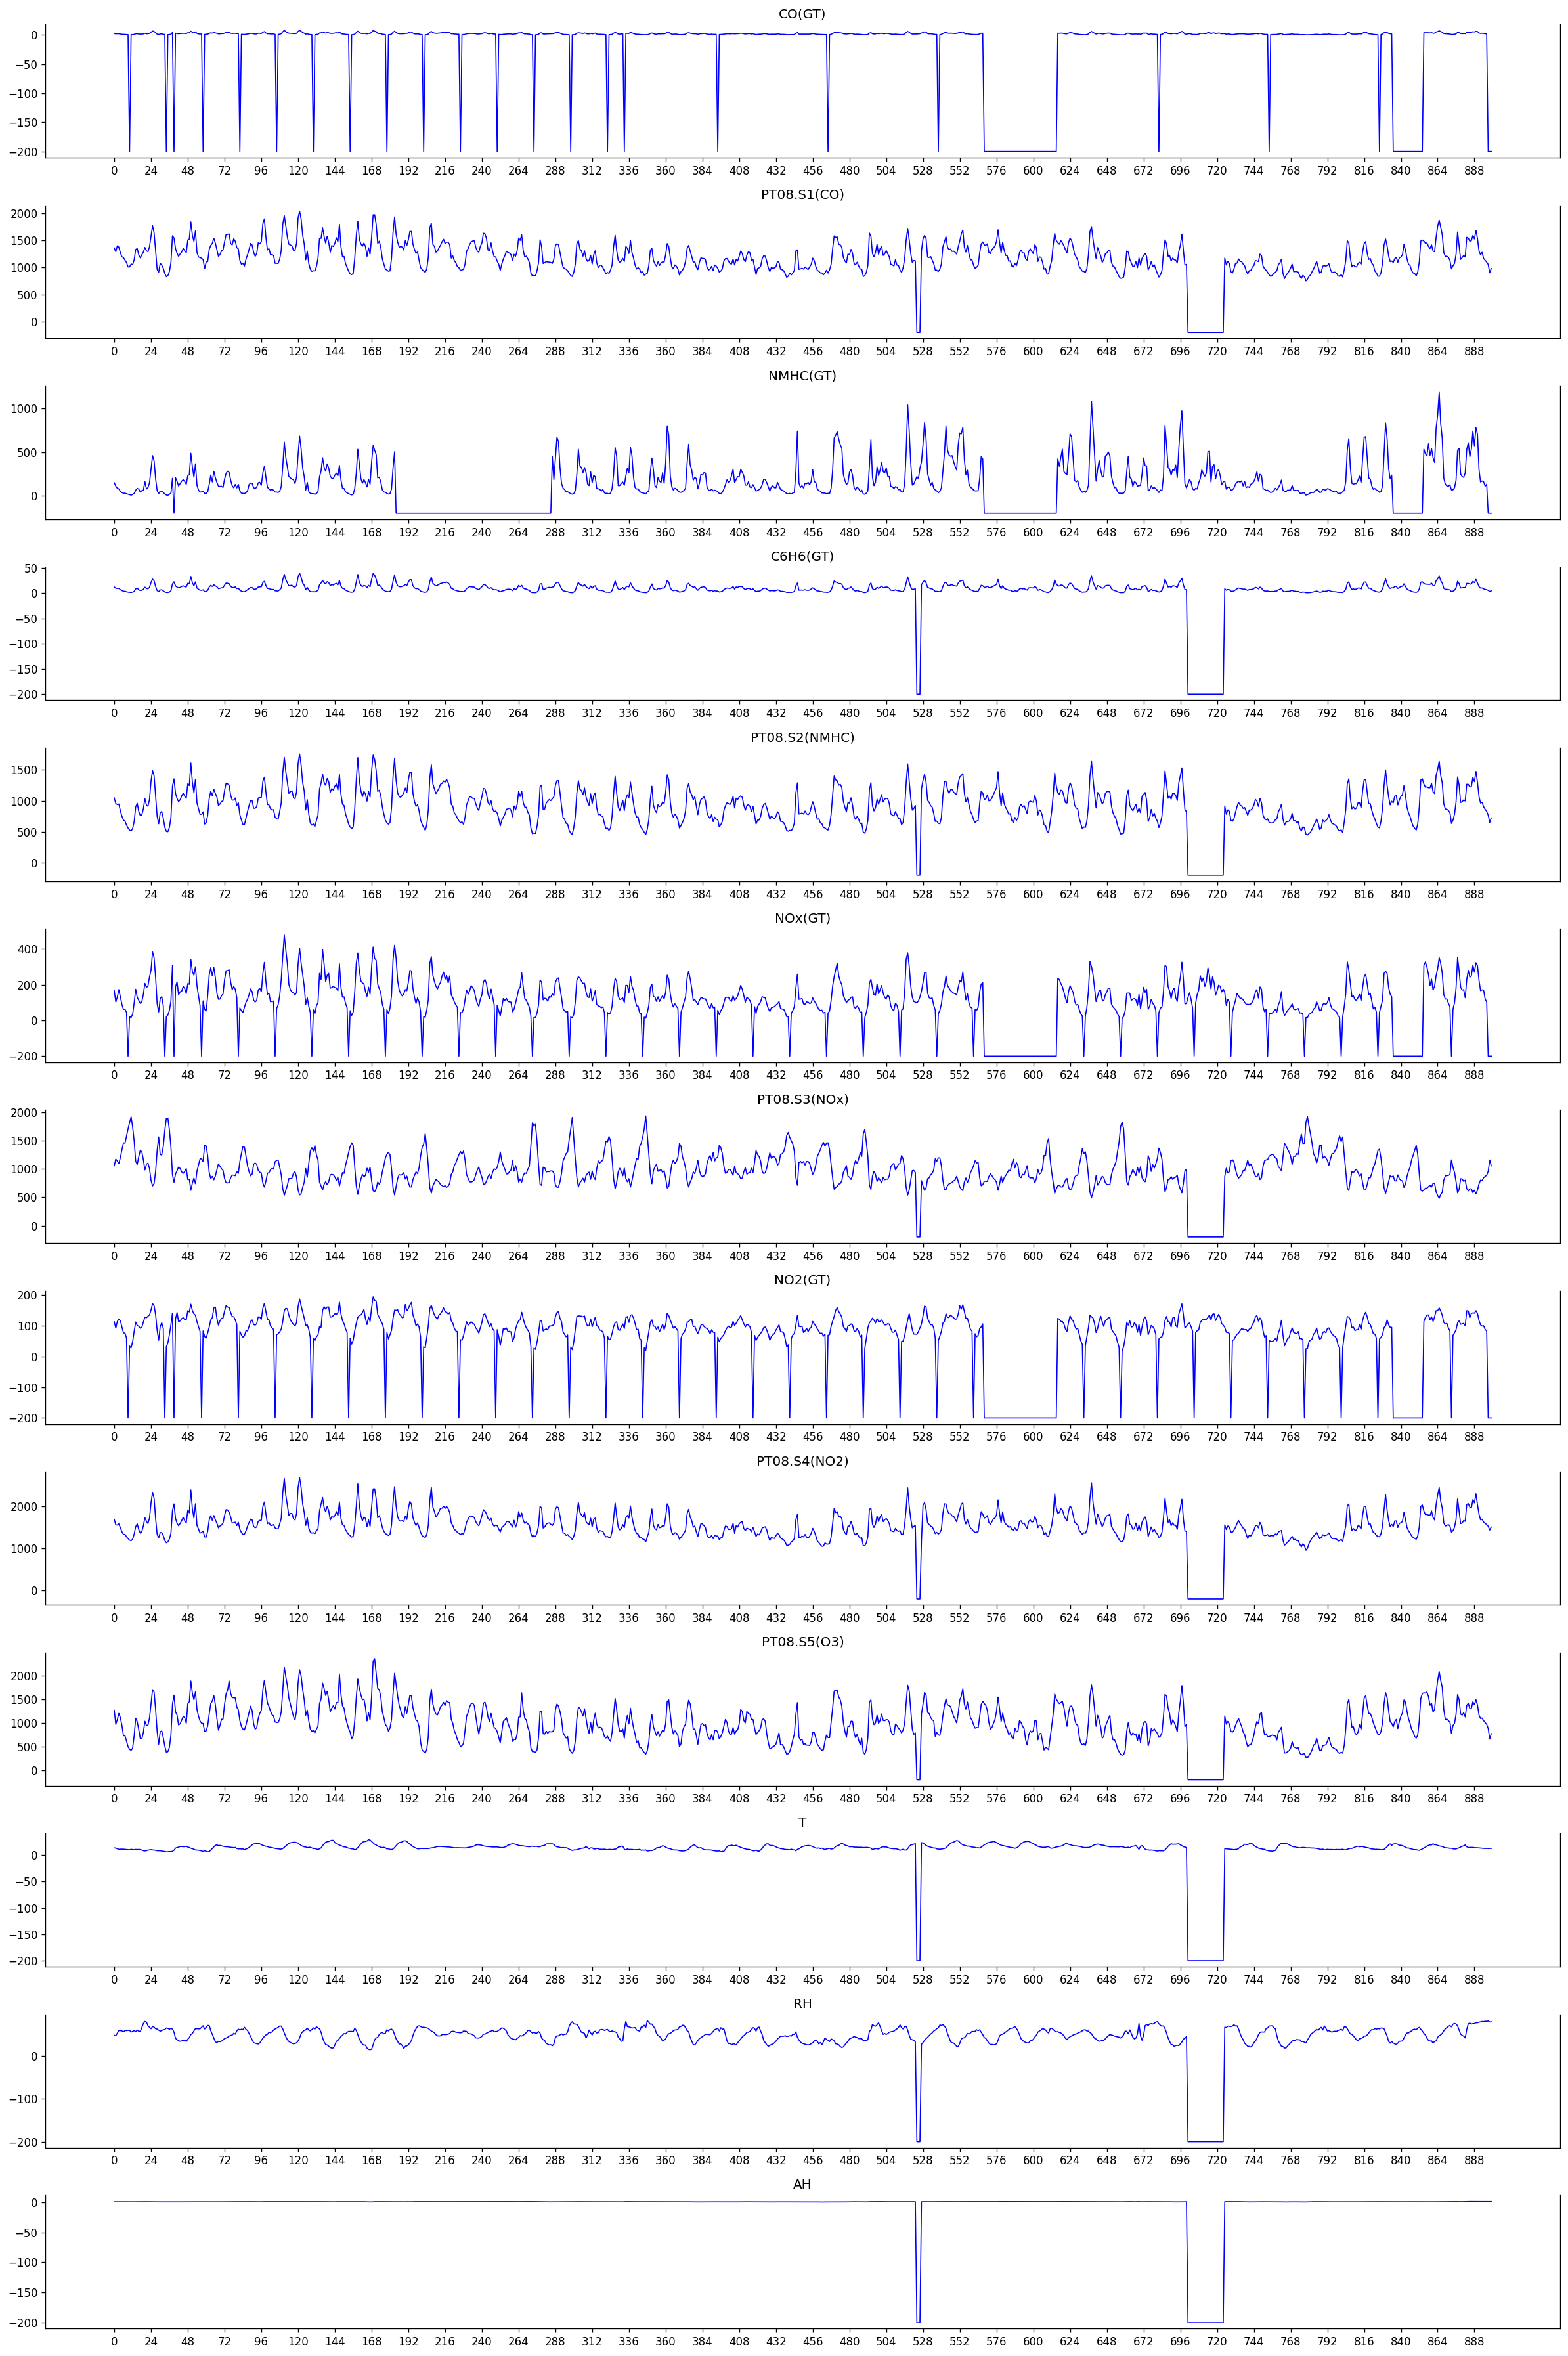

In [119]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

num_cols = len(df.columns)

def plot_data(df, full = True):
  fig, axes = plt.subplots(nrows= num_cols, ncols=1, dpi=120, figsize=(20,30))
  for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    if full == False:
      ax.set_xticks([24*x for x in range(38)])
      ax.plot(range(900), data[0:900], color='blue', linewidth=1)
    else:
      ax.plot(range(len(data)), data, color='blue', linewidth=1)
    ax.set_title(df.columns[i])
    ax.spines["top"].set_alpha(0)
        
  plt.tight_layout()

plot_data(df, full = False)

## The plots after differencing with a period of 24. The time series appear more stationary than before. The mean has stabilized for all time series. But, variance varies for NMHC(GT) (from big to small) and NOx(GT) (from small to big)

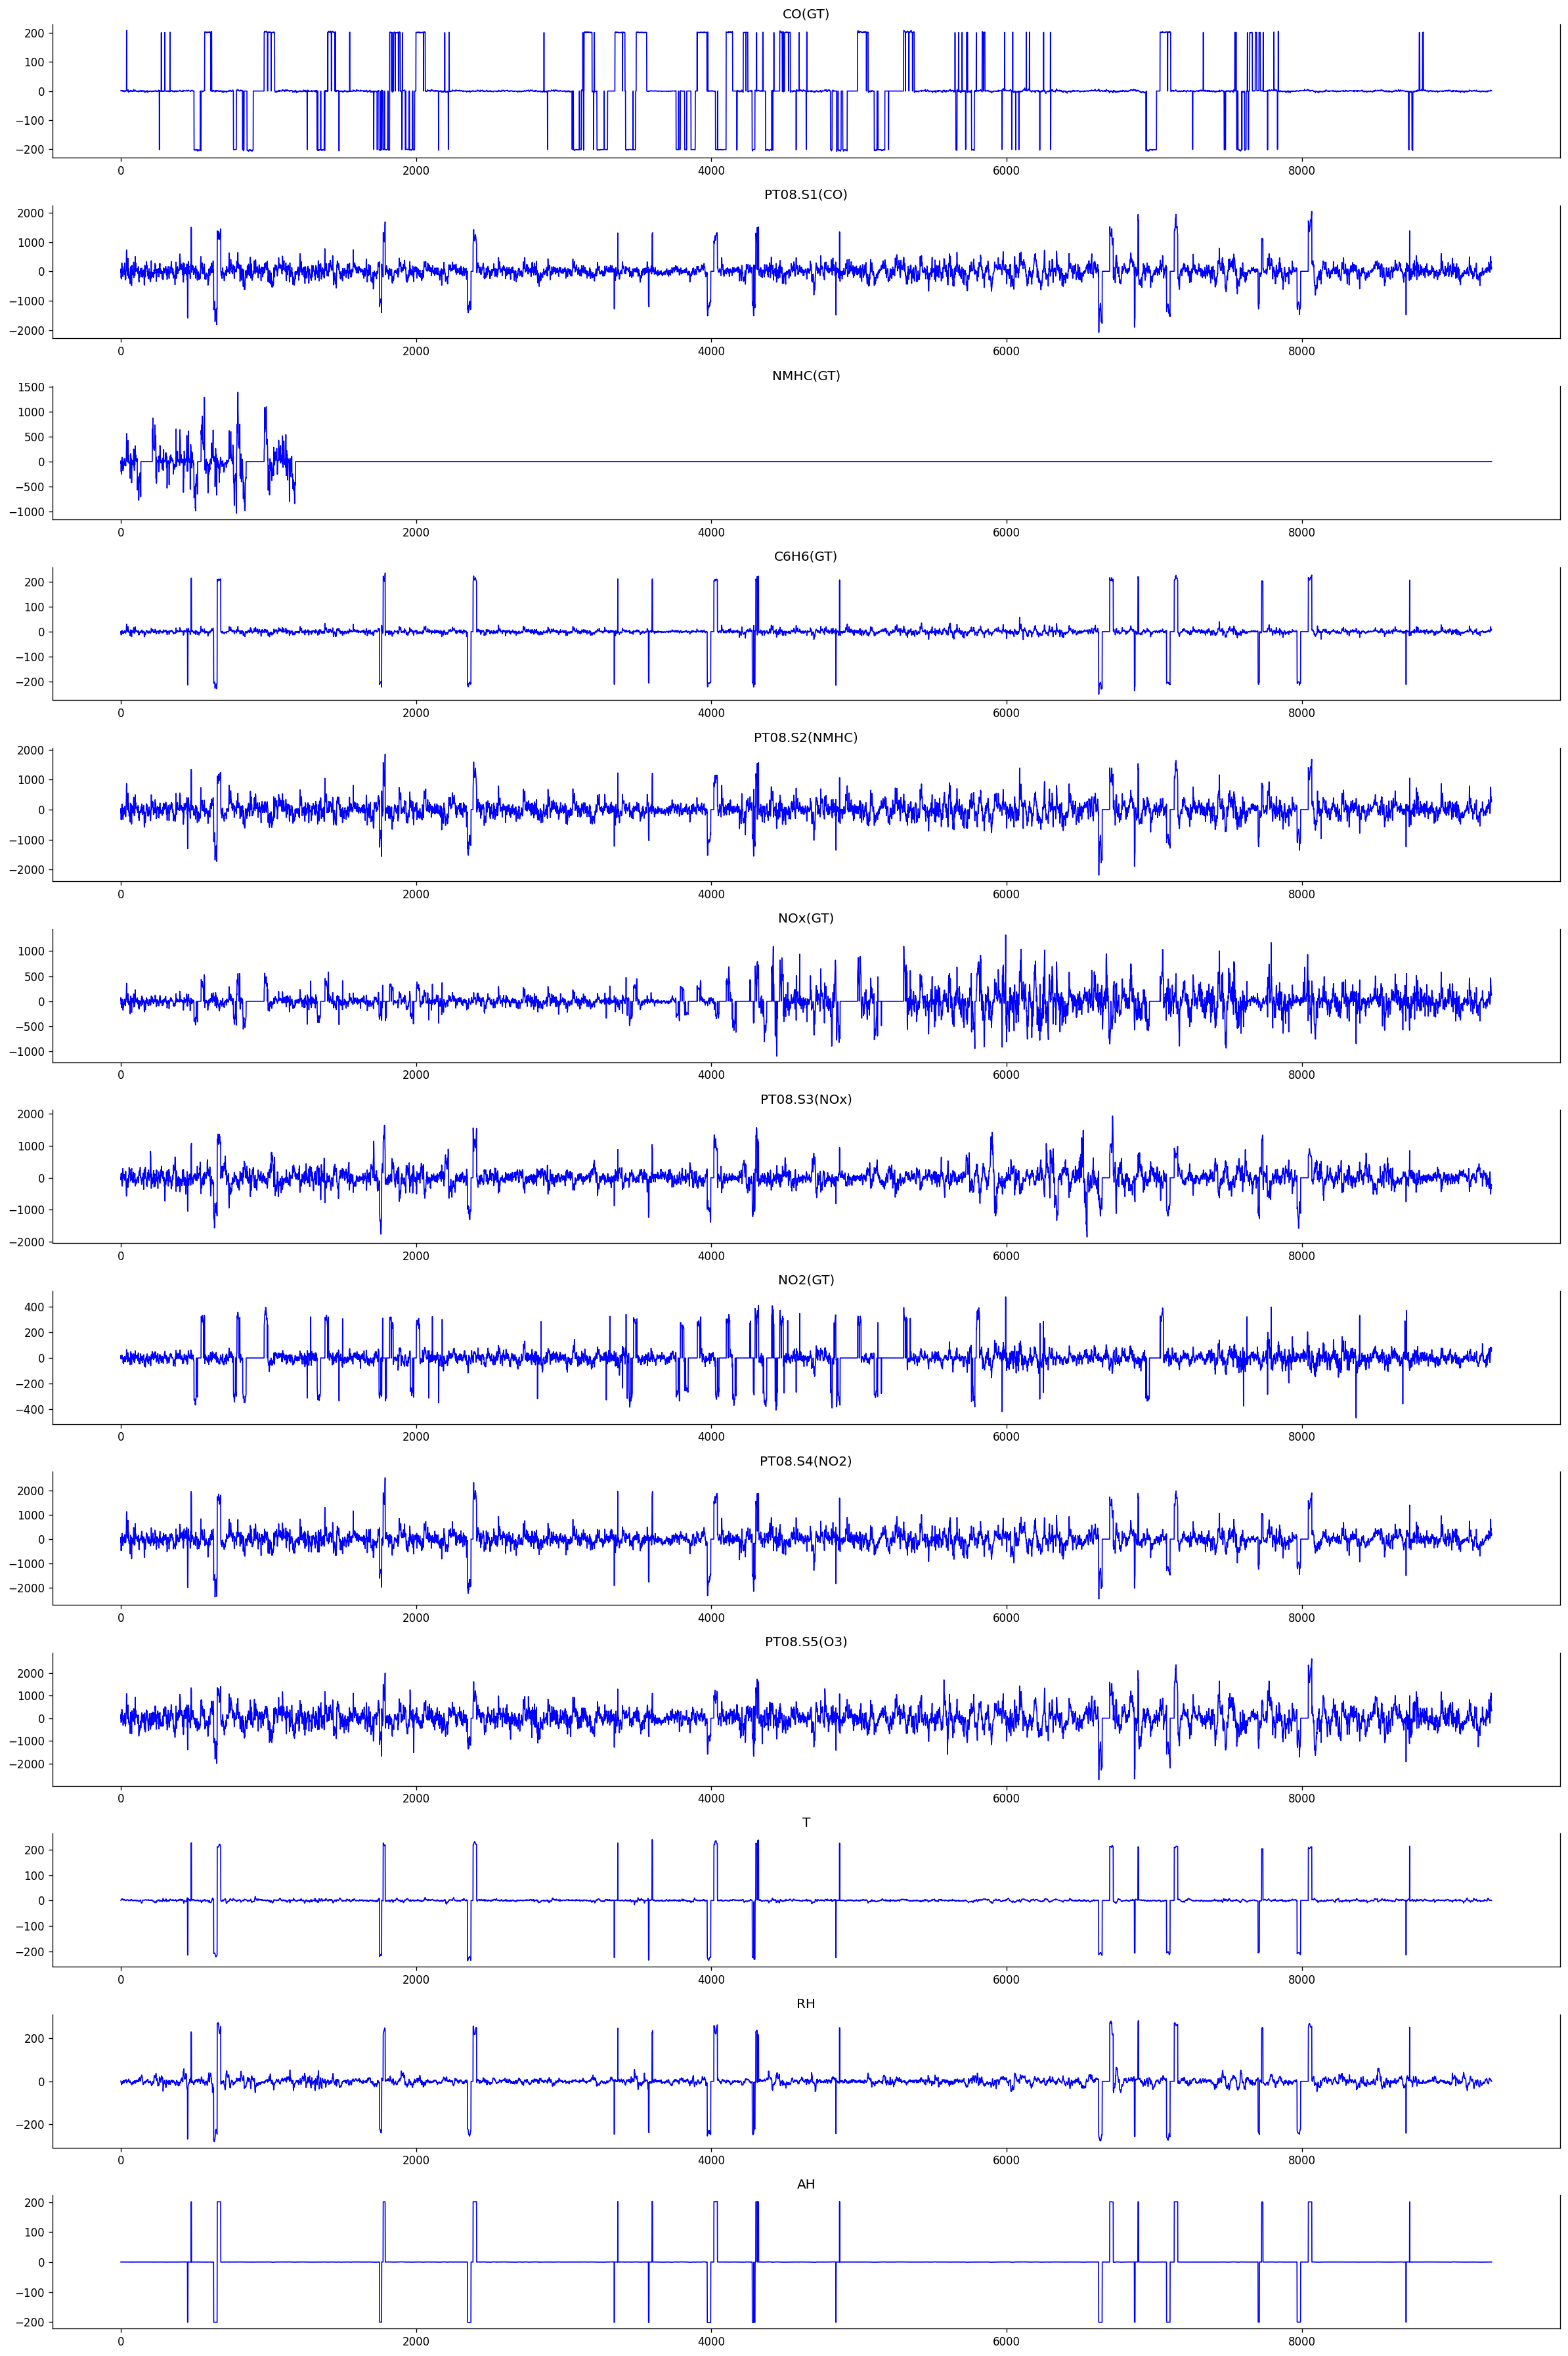

In [120]:
df_diff1 = df.copy()

for i in range(num_cols):
  if(i==0):
    df_diff1[df.columns[i]] = df[df.columns[i]].diff(periods = 72)
  else:
    df_diff1[df.columns[i]] = df[df.columns[i]].diff(periods = 24)
  
df_diff1 = df_diff1.dropna()
plot_data(df_diff1)

# Suitable offset is added to each time series to make all values > 0 and then log transformation is used to stabilize their variance. Now, variance looks more stable than before for all time series. But some outliers remain in the data.

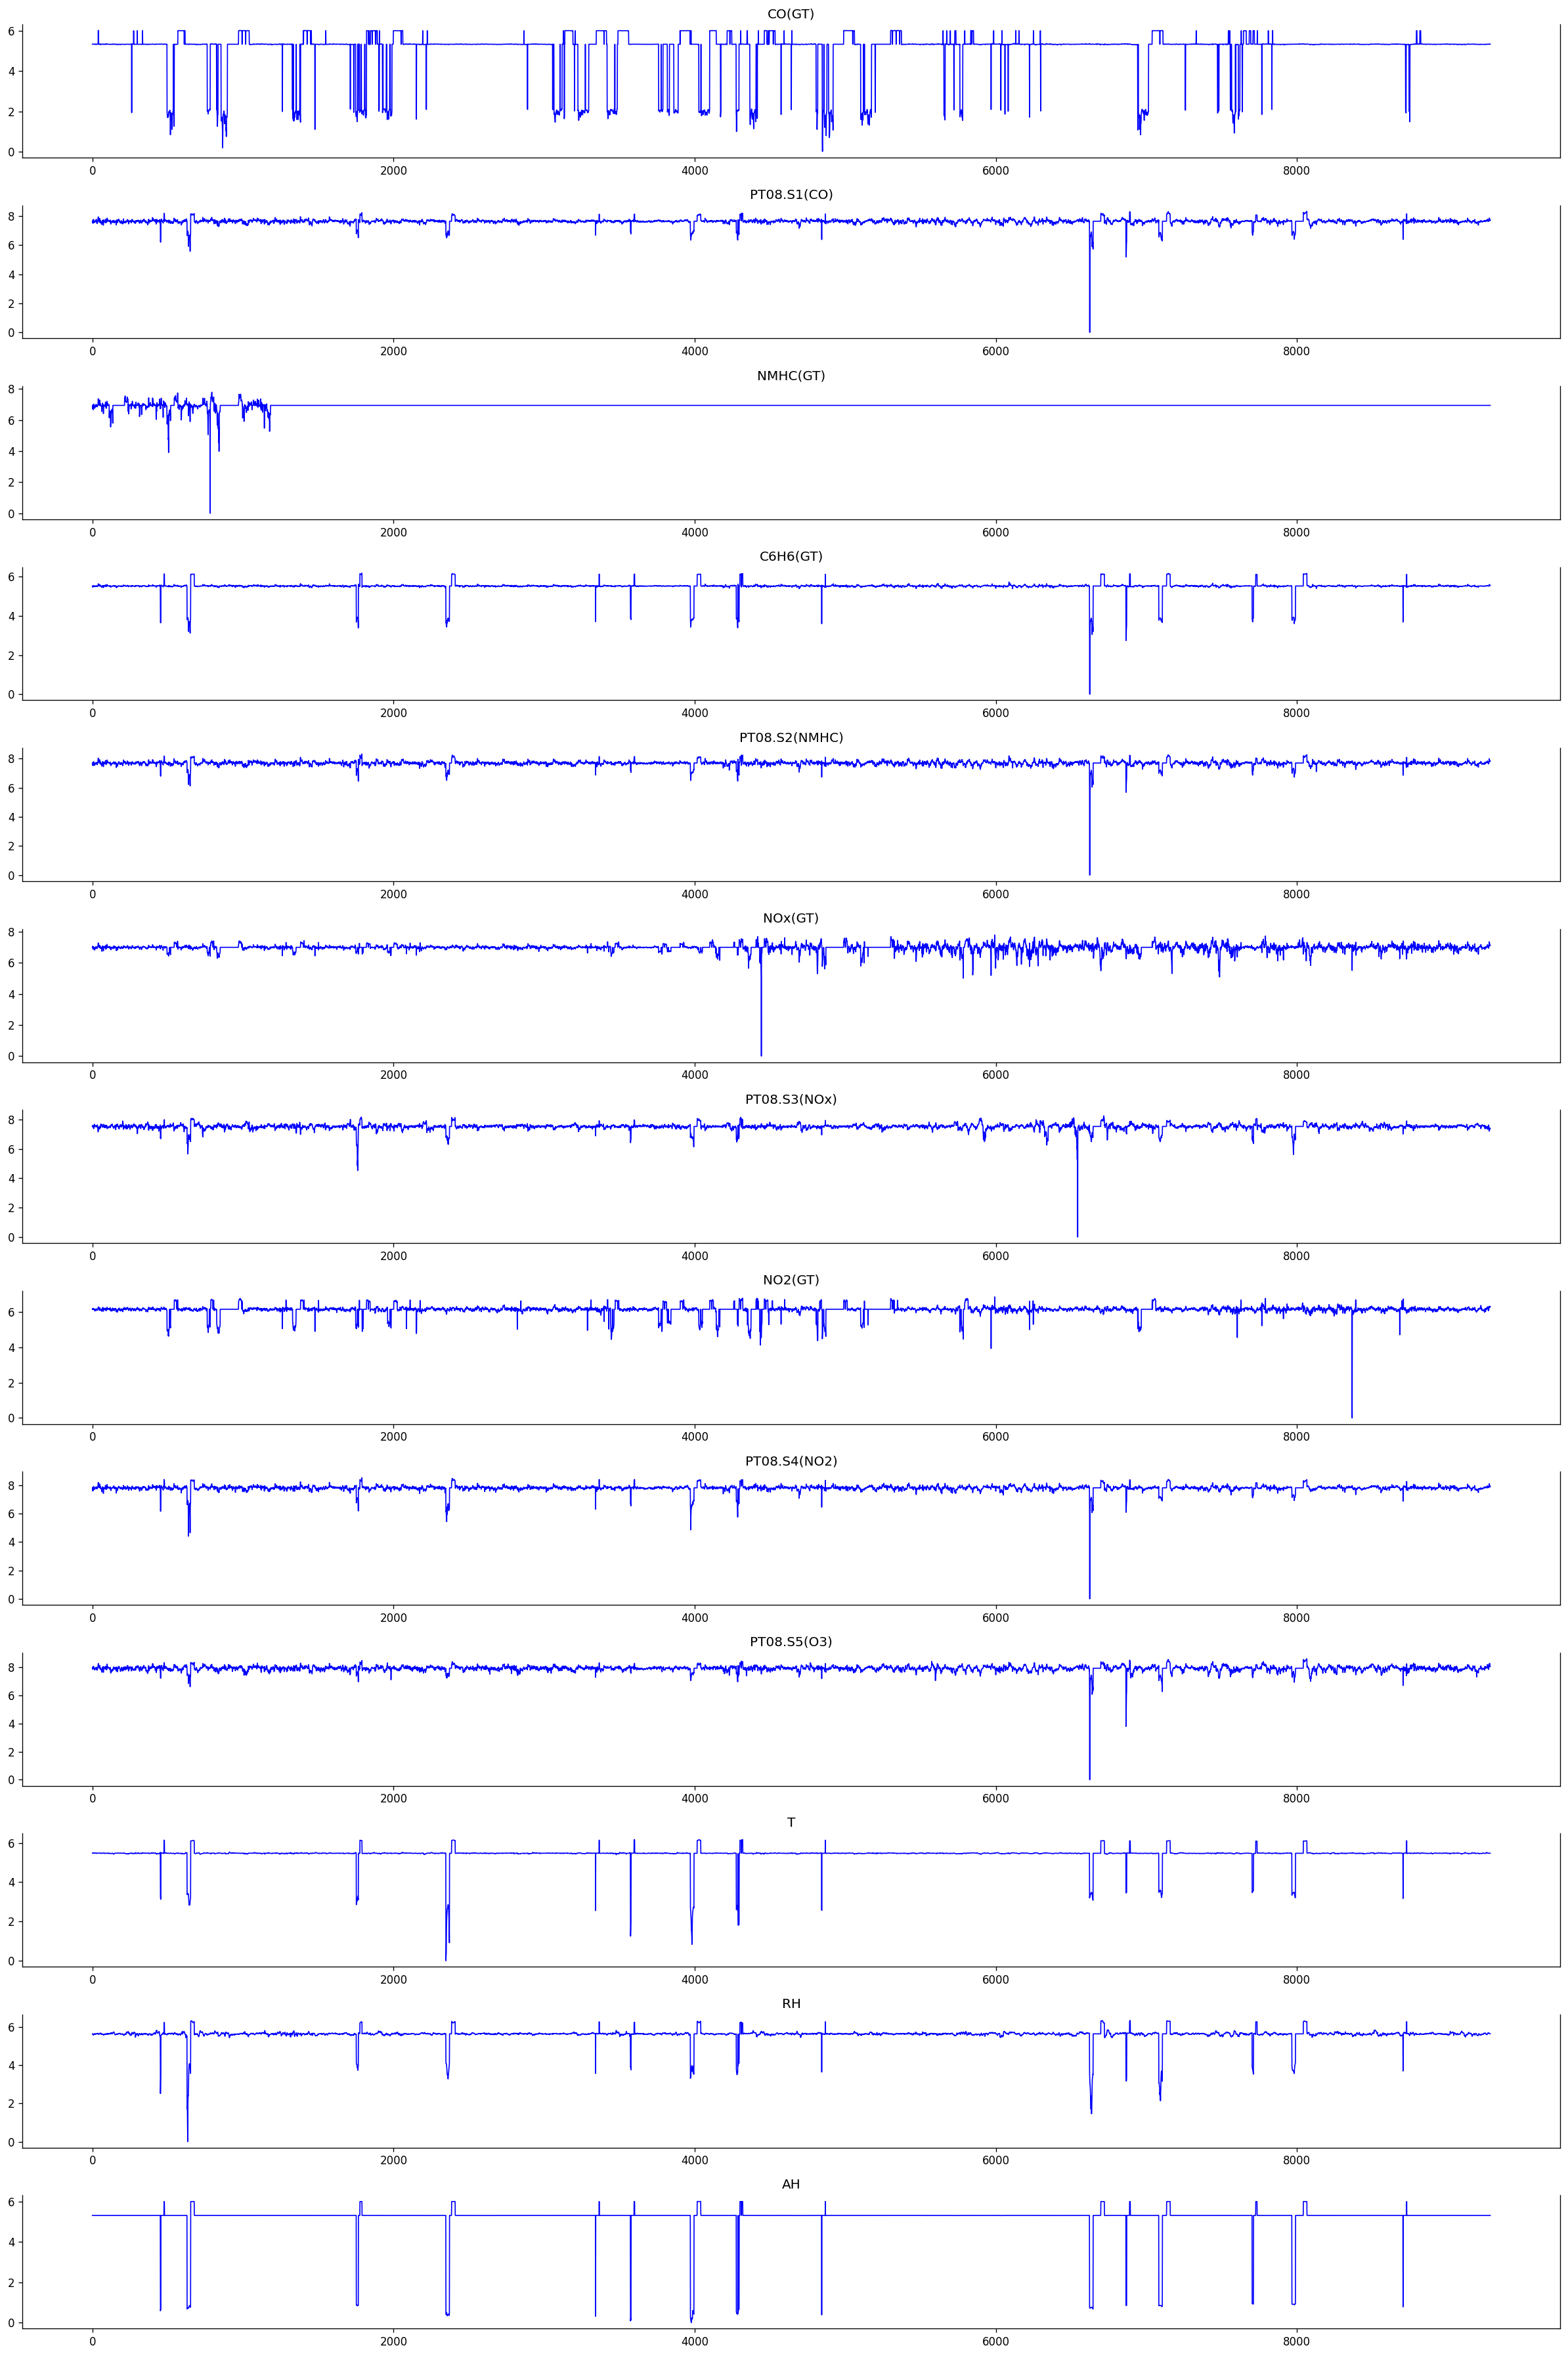

In [121]:
offsets = []

for i in range(num_cols):
  offset = -(np.min(df_diff1[df.columns[i]]) - 1)
  offsets.append(offset)
  
df_log = df_diff1 + offsets
df_log = df_log.apply(np.log)
plot_data(df_log)

## We eliminate all outliers from the time series which do not come in the range [mu - 3*sigma, mu + 3*sigma]. Now the graphs look much better

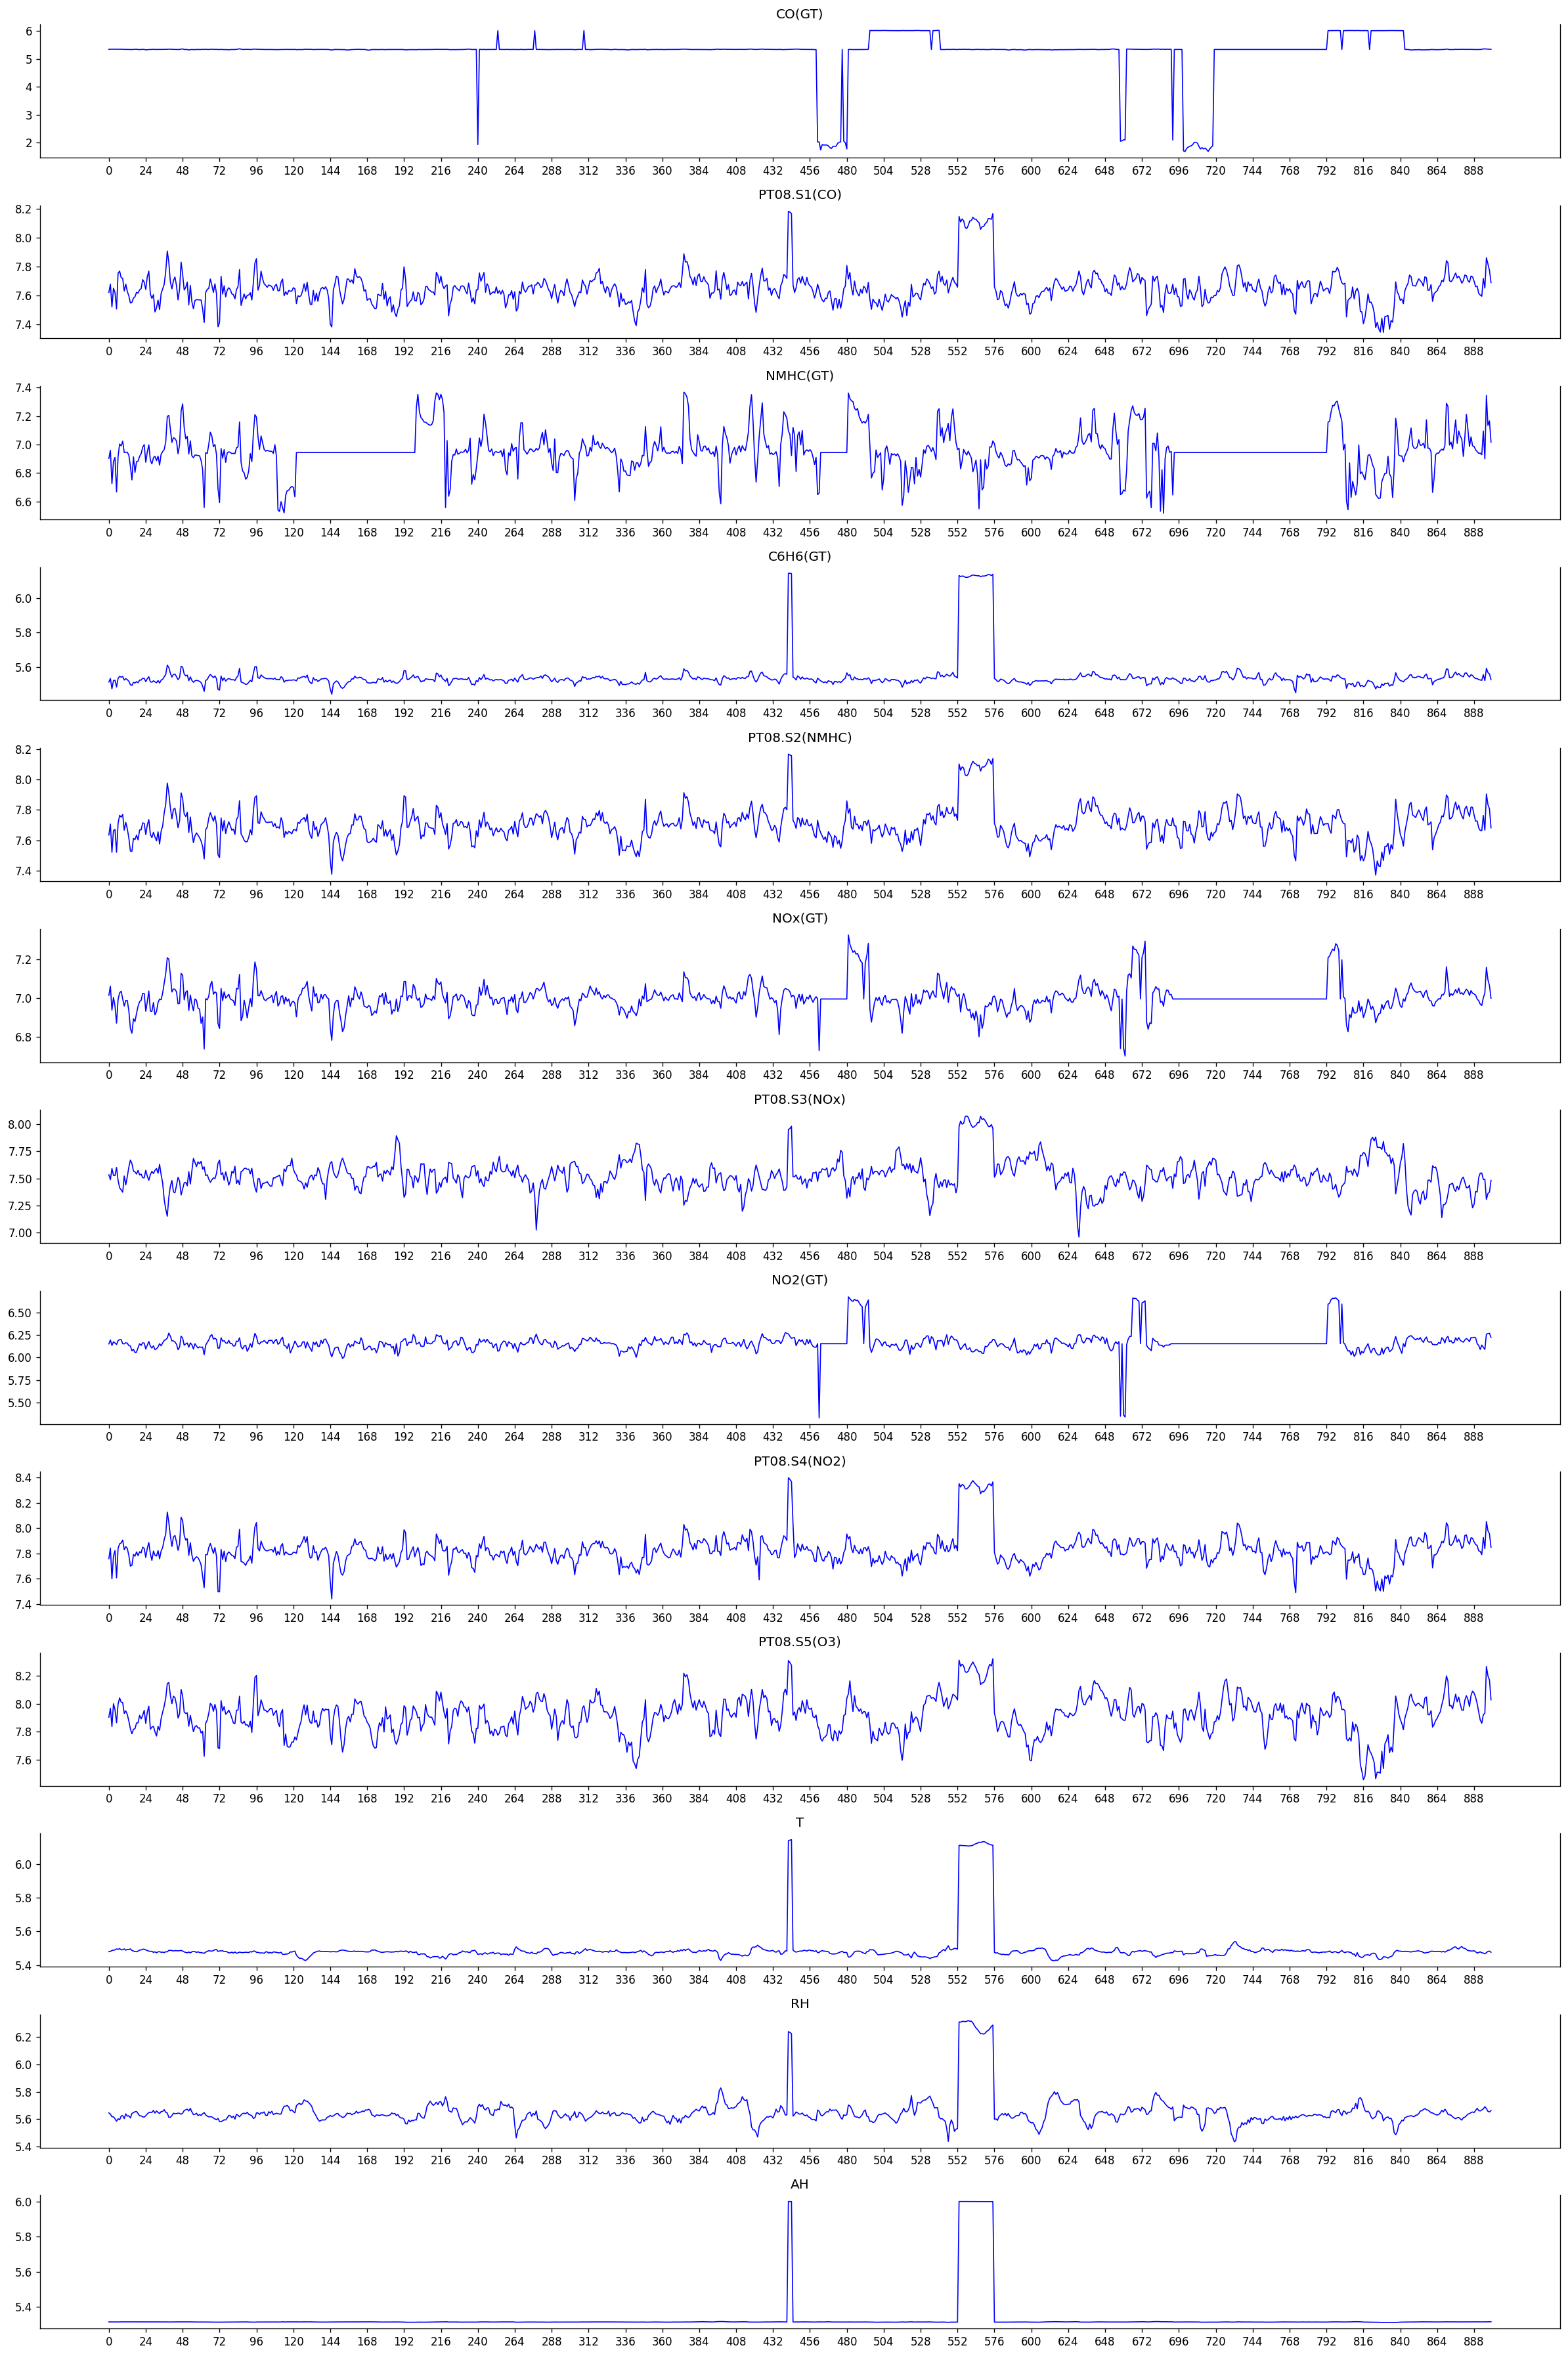

In [122]:
from scipy.stats import zscore

z_scores = zscore(df_log)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores<3).all(axis=1)
df_log_n = df_log[filtered_entries]

plot_data(df_log_n, full = False)

## Here is the correlation matrix of all time series. We can clearly see that PT08.S1(CO), PT08.S2(NMHC), PT08.S4(NO2) and PT08.S5(O3) are highly correlated with each other. The same goes for C6H6(GT), AH, RH and T too. So, there is a need for feature extraction to make our model more reliable.

In [123]:
df_log_n.corr()

CO(GT)  PT08.S1(CO)  NMHC(GT)  ...         T        RH        AH
CO(GT)         1.000000     0.002385  0.010471  ... -0.001912 -0.002577 -0.005998
PT08.S1(CO)    0.002385     1.000000  0.137449  ...  0.619750  0.665963  0.615371
NMHC(GT)       0.010471     0.137449  1.000000  ... -0.020685 -0.028869 -0.027739
C6H6(GT)      -0.009286     0.776642  0.026194  ...  0.954756  0.858633  0.960231
PT08.S2(NMHC) -0.014003     0.911315  0.150420  ...  0.509411  0.481278  0.500488
NOx(GT)        0.086671     0.481019  0.110664  ... -0.007999  0.061952 -0.005895
PT08.S3(NOx)  -0.004911    -0.253488 -0.163622  ...  0.455512  0.315523  0.470574
NO2(GT)        0.188495     0.241473  0.143638  ...  0.024597  0.031573  0.017663
PT08.S4(NO2)  -0.009115     0.950213  0.136881  ...  0.596906  0.657943  0.589615
PT08.S5(O3)   -0.011991     0.865068  0.176034  ...  0.360200  0.386014  0.356977
T             -0.001912     0.619750 -0.020685  ...  1.000000  0.842698  0.990185
RH            -0.002577     0.665963 -0.028869  ...  0.842698  1.000000  0.887079
AH            -0.005998     0.615371 -0.027739  ...  0.990185  0.887079  1.000000

[13 rows x 13 columns]

## We use PCA for the feature extraction. Given below is the variance ratio plot of the principal components. The graph saturates after 3 components. So, we choose the top 3 principal components.

Text(0, 0.5, 'cumulative explained variance')

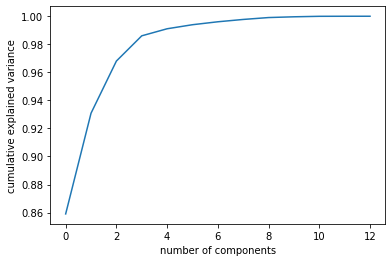

In [124]:
from sklearn.decomposition import PCA

pca = PCA().fit(df_log_n)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## PCA feature extraction:

In [125]:
num_cols = 3
pca = PCA(n_components=num_cols)
df_pca = pca.fit_transform(df_log_n)
df_pca = pd.DataFrame(data = df_pca, columns = np.array(['Principal Component 1', 'Principal Component 2', 'Principal Component 3']))
df_pca

Principal Component 1  Principal Component 2  Principal Component 3
0                 -0.188342              -0.067713              -0.021217
1                 -0.197799               0.081906              -0.056276
2                 -0.193587              -0.296317              -0.005859
3                 -0.195360               0.004918              -0.026856
4                 -0.191971              -0.028234              -0.005546
...                     ...                    ...                    ...
8442              -0.202731               0.500544              -0.205533
8443              -0.197541               0.299394              -0.138267
8444              -0.195595               0.249554              -0.108004
8445              -0.194404               0.205716              -0.140966
8446              -0.197180               0.265864              -0.151676

[8447 rows x 3 columns]

# We again remove the outliers in the data just as done earlier. Here are the plots for the 3 principal components. The plots look stationary.

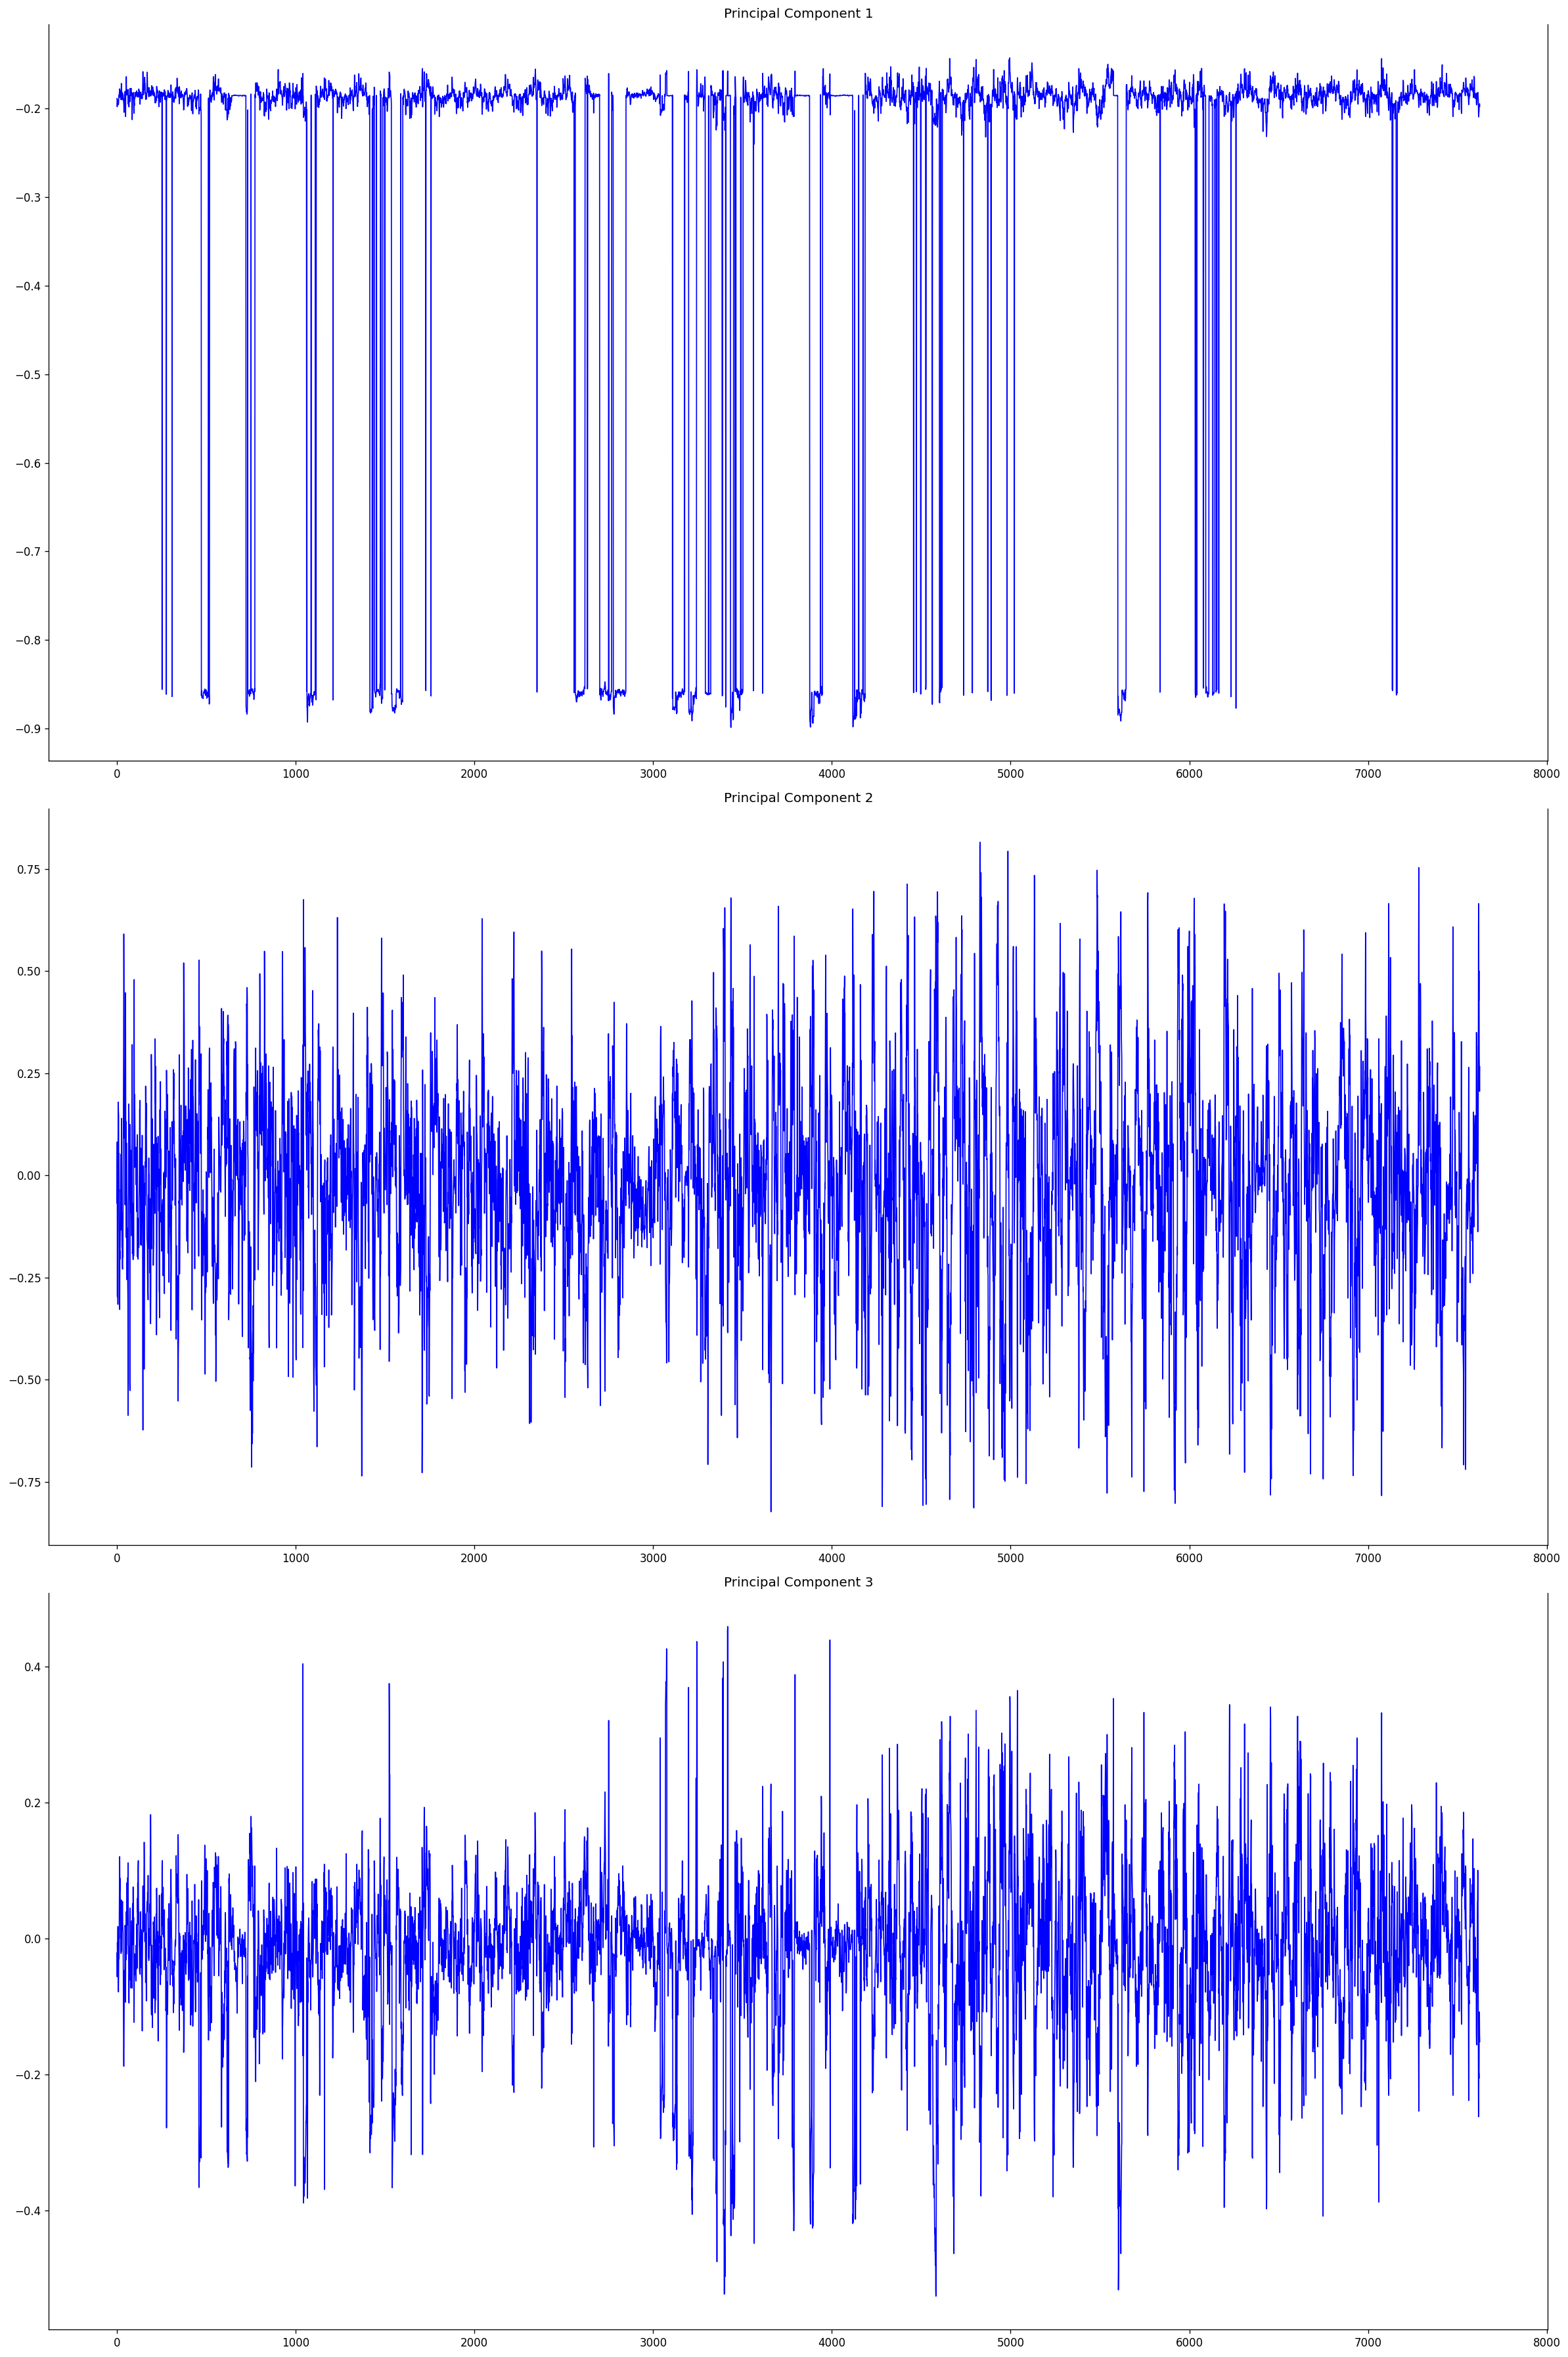

In [126]:
z_scores = zscore(df_pca)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores<3).all(axis=1)
df_pca = df_pca[filtered_entries]
plot_data(df_pca)

## The lag plot (all 3 time series combined) for the transformed data. The plot is not random. Also, a linear trend exists, thus giving us confidence that a VAR model is suitable to describe the data.

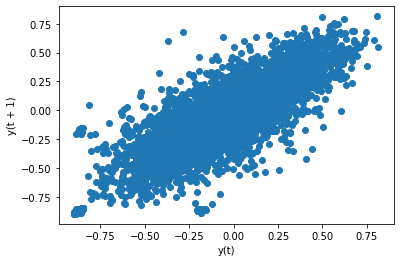

In [127]:
pd.plotting.lag_plot(df_pca)

## Given below are the plots for the autocorrelation of each individual time series. None of the time series is insignificant (close to 0) for all time lags. Also, the plots decay after certain number of lags. This gives us further confidence that the data can be modelled using a VAR model.

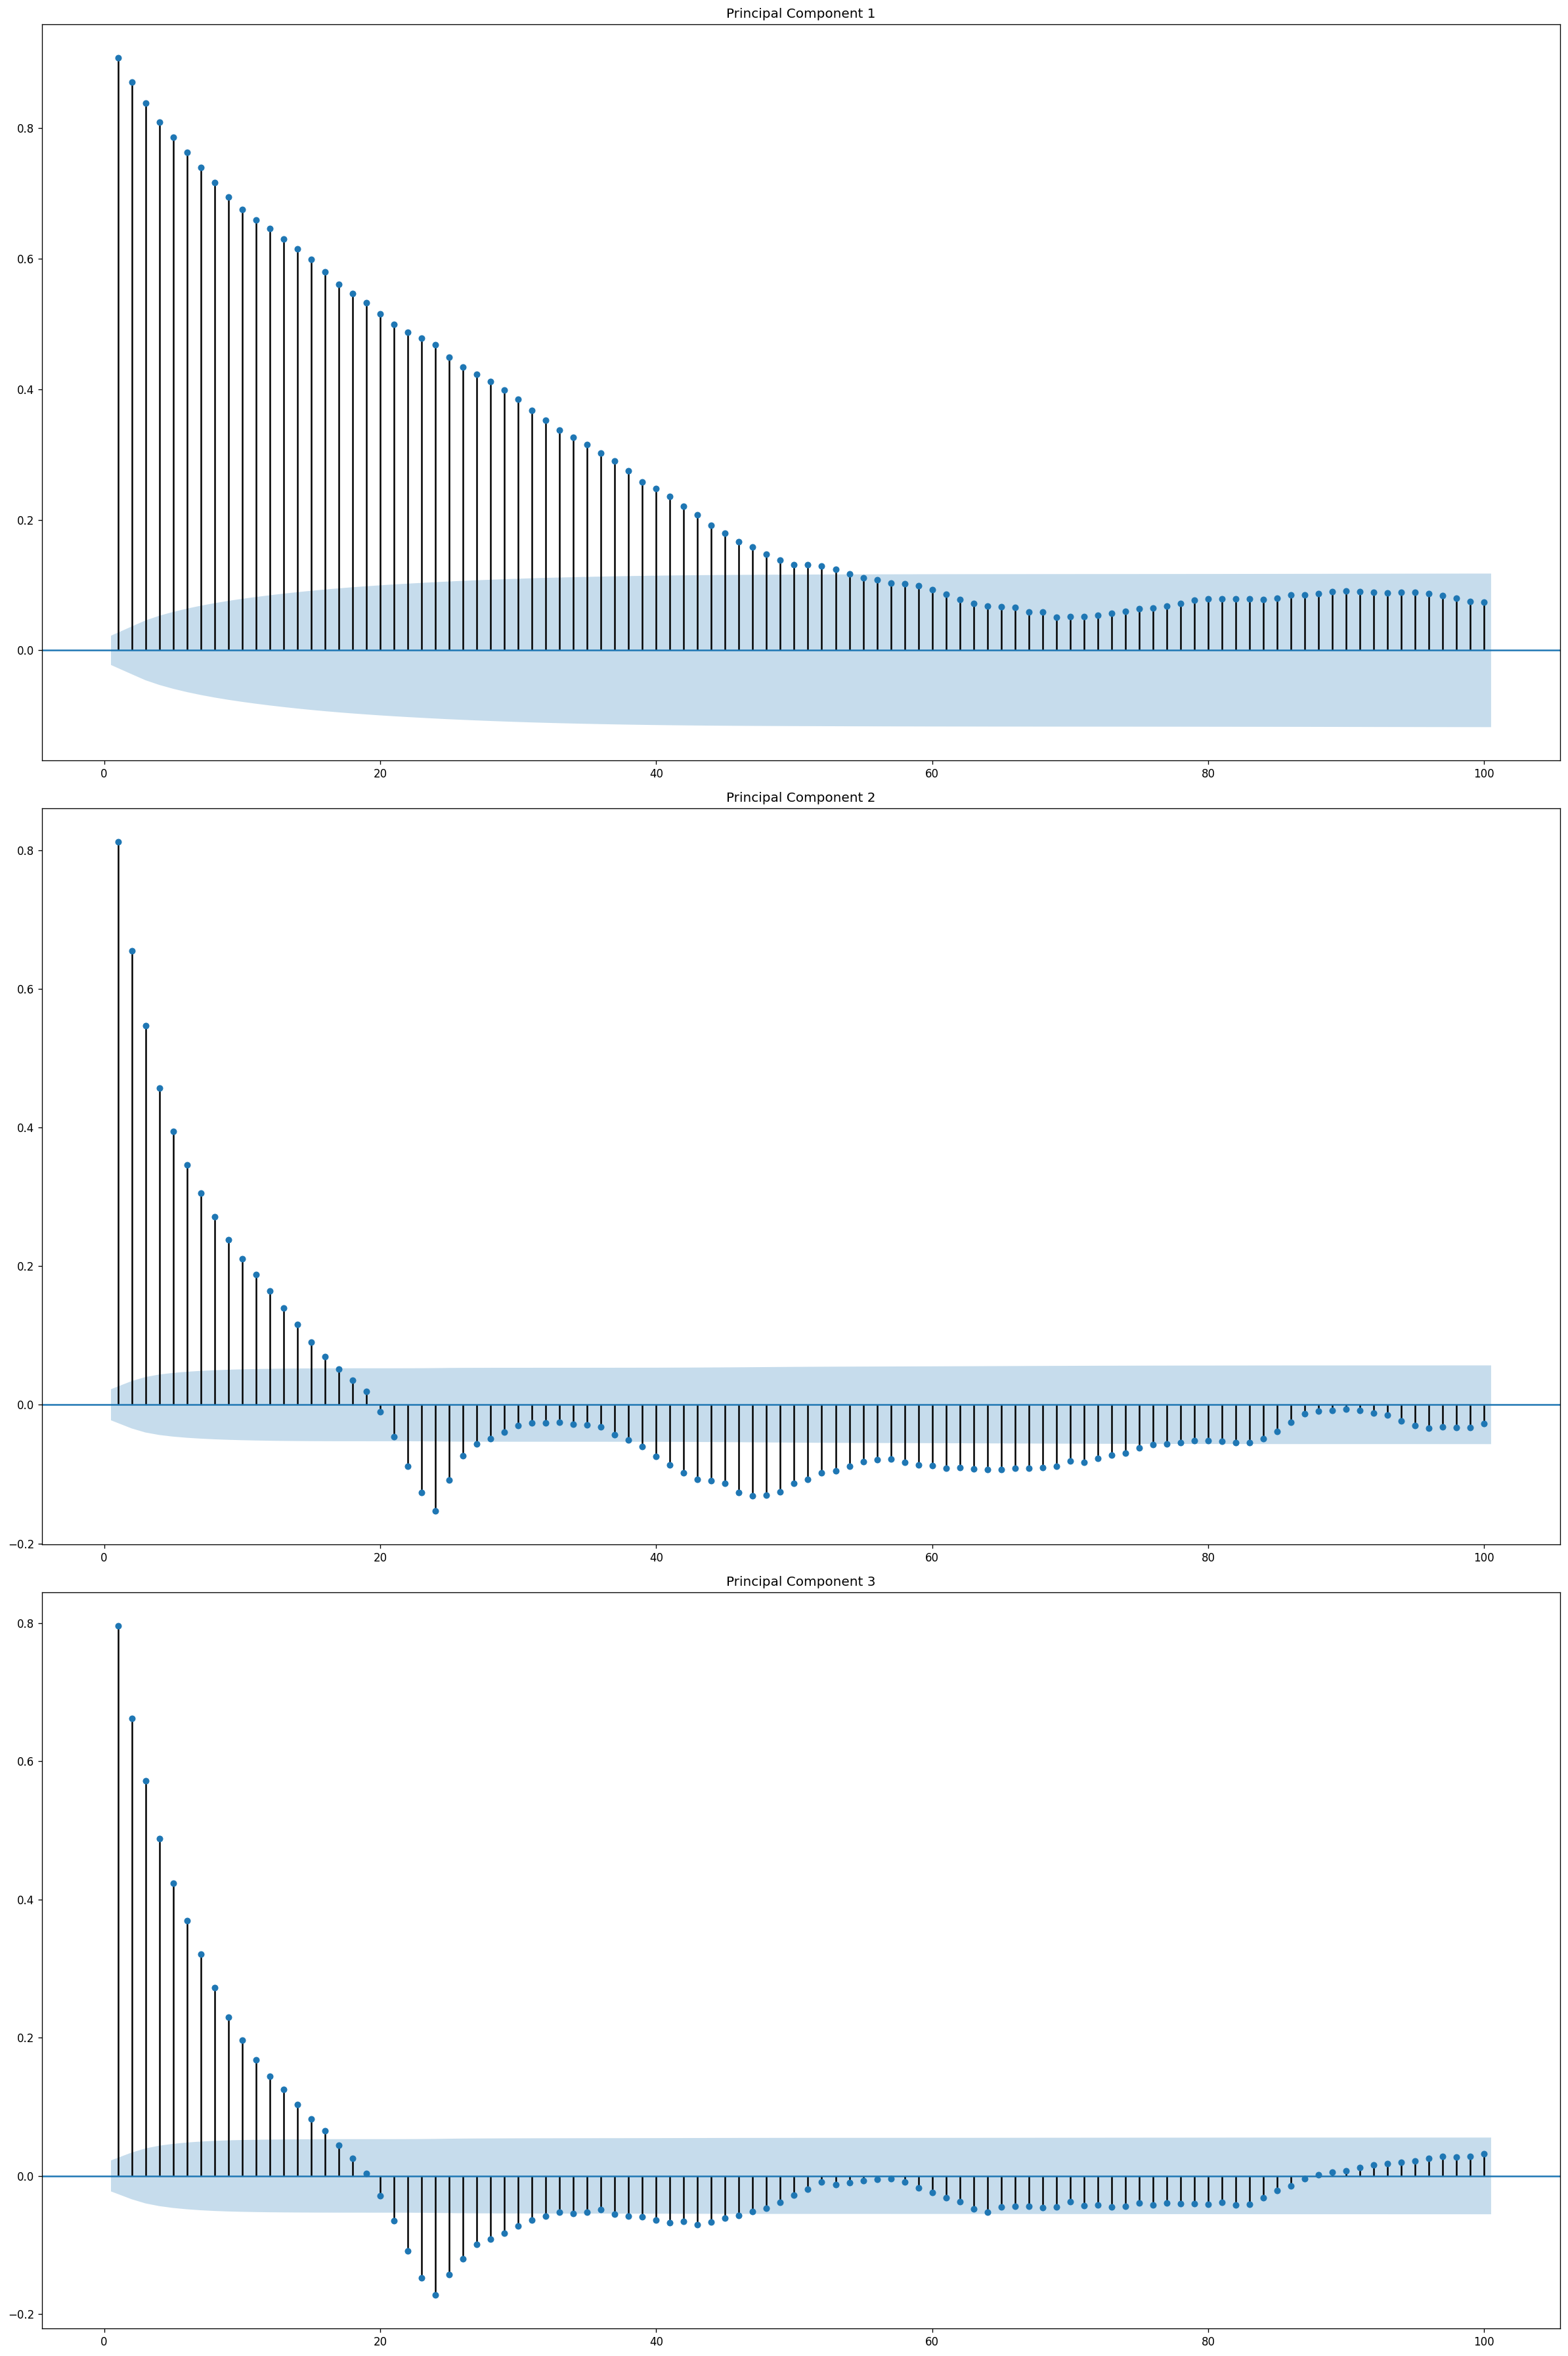

In [128]:
import statsmodels.tsa.api as smt

fig, axes = plt.subplots(nrows= num_cols, ncols=1, dpi=120, figsize=(20,30))
for i, ax in enumerate(axes.flatten()):
  smt.graphics.plot_acf(df_pca[df_pca.columns[i]], lags=100, ax=ax, title = df_pca.columns[i], zero = False)
  
plt.tight_layout()  

## Train test split is implemented below. We forecast the values for 20 hours after the end of train set for each time series

In [0]:
nobs = 20
df_train, df_test = df_pca[0:-nobs], df[-nobs:]

## We perform the ADF Test to test for the stationarity of each time series. The p-value turns out to be insignificant for all time series. This gives us further confidence that the dataset is stationary 

In [130]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  
          
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')          

    Augmented Dickey-Fuller Test on "Principal Component 1" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.2589
 No. Lags Chosen       = 30
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Principal Component 2" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.5796
 No. Lags Chosen       = 24
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Principal Component 3" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

## We calculate the AIC, BIC, FPE and HQIC for the first 20 lags to determine the appropriate lag order of the model. According to AIC: the lag order is 6, according to BIC: 2, according to FPE: 5 and according to HQIC: 2. We chose the lag order as 6 as according to our experiments, choosing 6 resulted in a better accuracy of the model. 

In [131]:
model = VAR(df_train)
for i in range(20):
    if(i==0):
      continue
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -14.971960699385521
BIC :  -14.961015435157208
FPE :  3.146009901194007e-07
HQIC:  -14.968204799227829 

Lag Order = 2
AIC :  -15.069071504478034
BIC :  -15.049915136280273
FPE :  2.8548638338297584e-07
HQIC:  -15.062497896088885 

Lag Order = 3
AIC :  -15.090192630656391
BIC :  -15.062823309920253
FPE :  2.795198223525028e-07
HQIC:  -15.080800642518607 

Lag Order = 4
AIC :  -15.091969144123219
BIC :  -15.056385021611721
FPE :  2.79023693966049e-07
HQIC:  -15.07975810446991 

Lag Order = 5
AIC :  -15.095147506713545
BIC :  -15.05134673252131
FPE :  2.7813826575708634e-07
HQIC:  -15.080116743527983 

Lag Order = 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


6
AIC :  -15.094917419323028
BIC :  -15.042898142875972
FPE :  2.782022727319559e-07
HQIC:  -15.077066260338524 

Lag Order = 7
AIC :  -15.095148205019804
BIC :  -15.034908575074784
FPE :  2.7813807984167244e-07
HQIC:  -15.074475977719578 

Lag Order = 8
AIC :  -15.095199341246648
BIC :  -15.02673750589115
FPE :  2.781238635903452e-07
HQIC:  -15.071705372863708 

Lag Order = 9
AIC :  -15.093480474055617
BIC :  -15.016794580707417
FPE :  2.786023407176069e-07
HQIC:  -15.067164091572629 

Lag Order = 10
AIC :  -15.092101394783215
BIC :  -15.007189590190048
FPE :  2.7898683047496766e-07
HQIC:  -15.062961924932381 

Lag Order = 11
AIC :  -15.09145774025259
BIC :  -14.998318170491821
FPE :  2.7916647155437543e-07
HQIC:  -15.059494509515517 

Lag Order = 12
AIC :  -15.090647028191214
BIC :  -14.989277838669501
FPE :  2.7939290144731816e-07
HQIC:  -15.05585936279879 

Lag Order = 13
AIC :  -15.090451912062717
BIC :  -14.980851247515687
FPE :  2.794474378933503e-07
HQIC:  -15.052839137994988 


## Given below is the model summary. None of the 3 equations have all the co-efficients as insignificant (Close to 0). That gives us confidence that the model is reliable.

In [132]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 01, Jun, 2020
Time:                     20:46:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.0429
Nobs:                     7600.00    HQIC:                  -15.0771
Log likelihood:           25065.9    FPE:                2.78202e-07
AIC:                     -15.0949    Det(Omega_mle):     2.76126e-07
--------------------------------------------------------------------
Results for equation Principal Component 1
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.013561         0.001694           -8.004           0.000
L1.Principal Component 1         0.627809         0.011512           54.537           0.000


## We test for stability of the model below. The model turns out to be stable.

In [133]:
model_fitted.is_stable()

True

## The autocorrelation plot of the residuals are shown below. We see that there is some leftover correlation at lag number 24 for all the 3 time series. Also, there is some leftover correlation at lag number 48 and 72 as well in Principal Component 1 and 3. This is not surprising given that we have 24-hour seasonality in the data. Such cases can only be dealt with dynamic VAR models, which take the error terms into account as well in the regression model. 

## We ignore this residual autocorrelation as apart from this, there is no other significant residual autocorrelation left in the model.

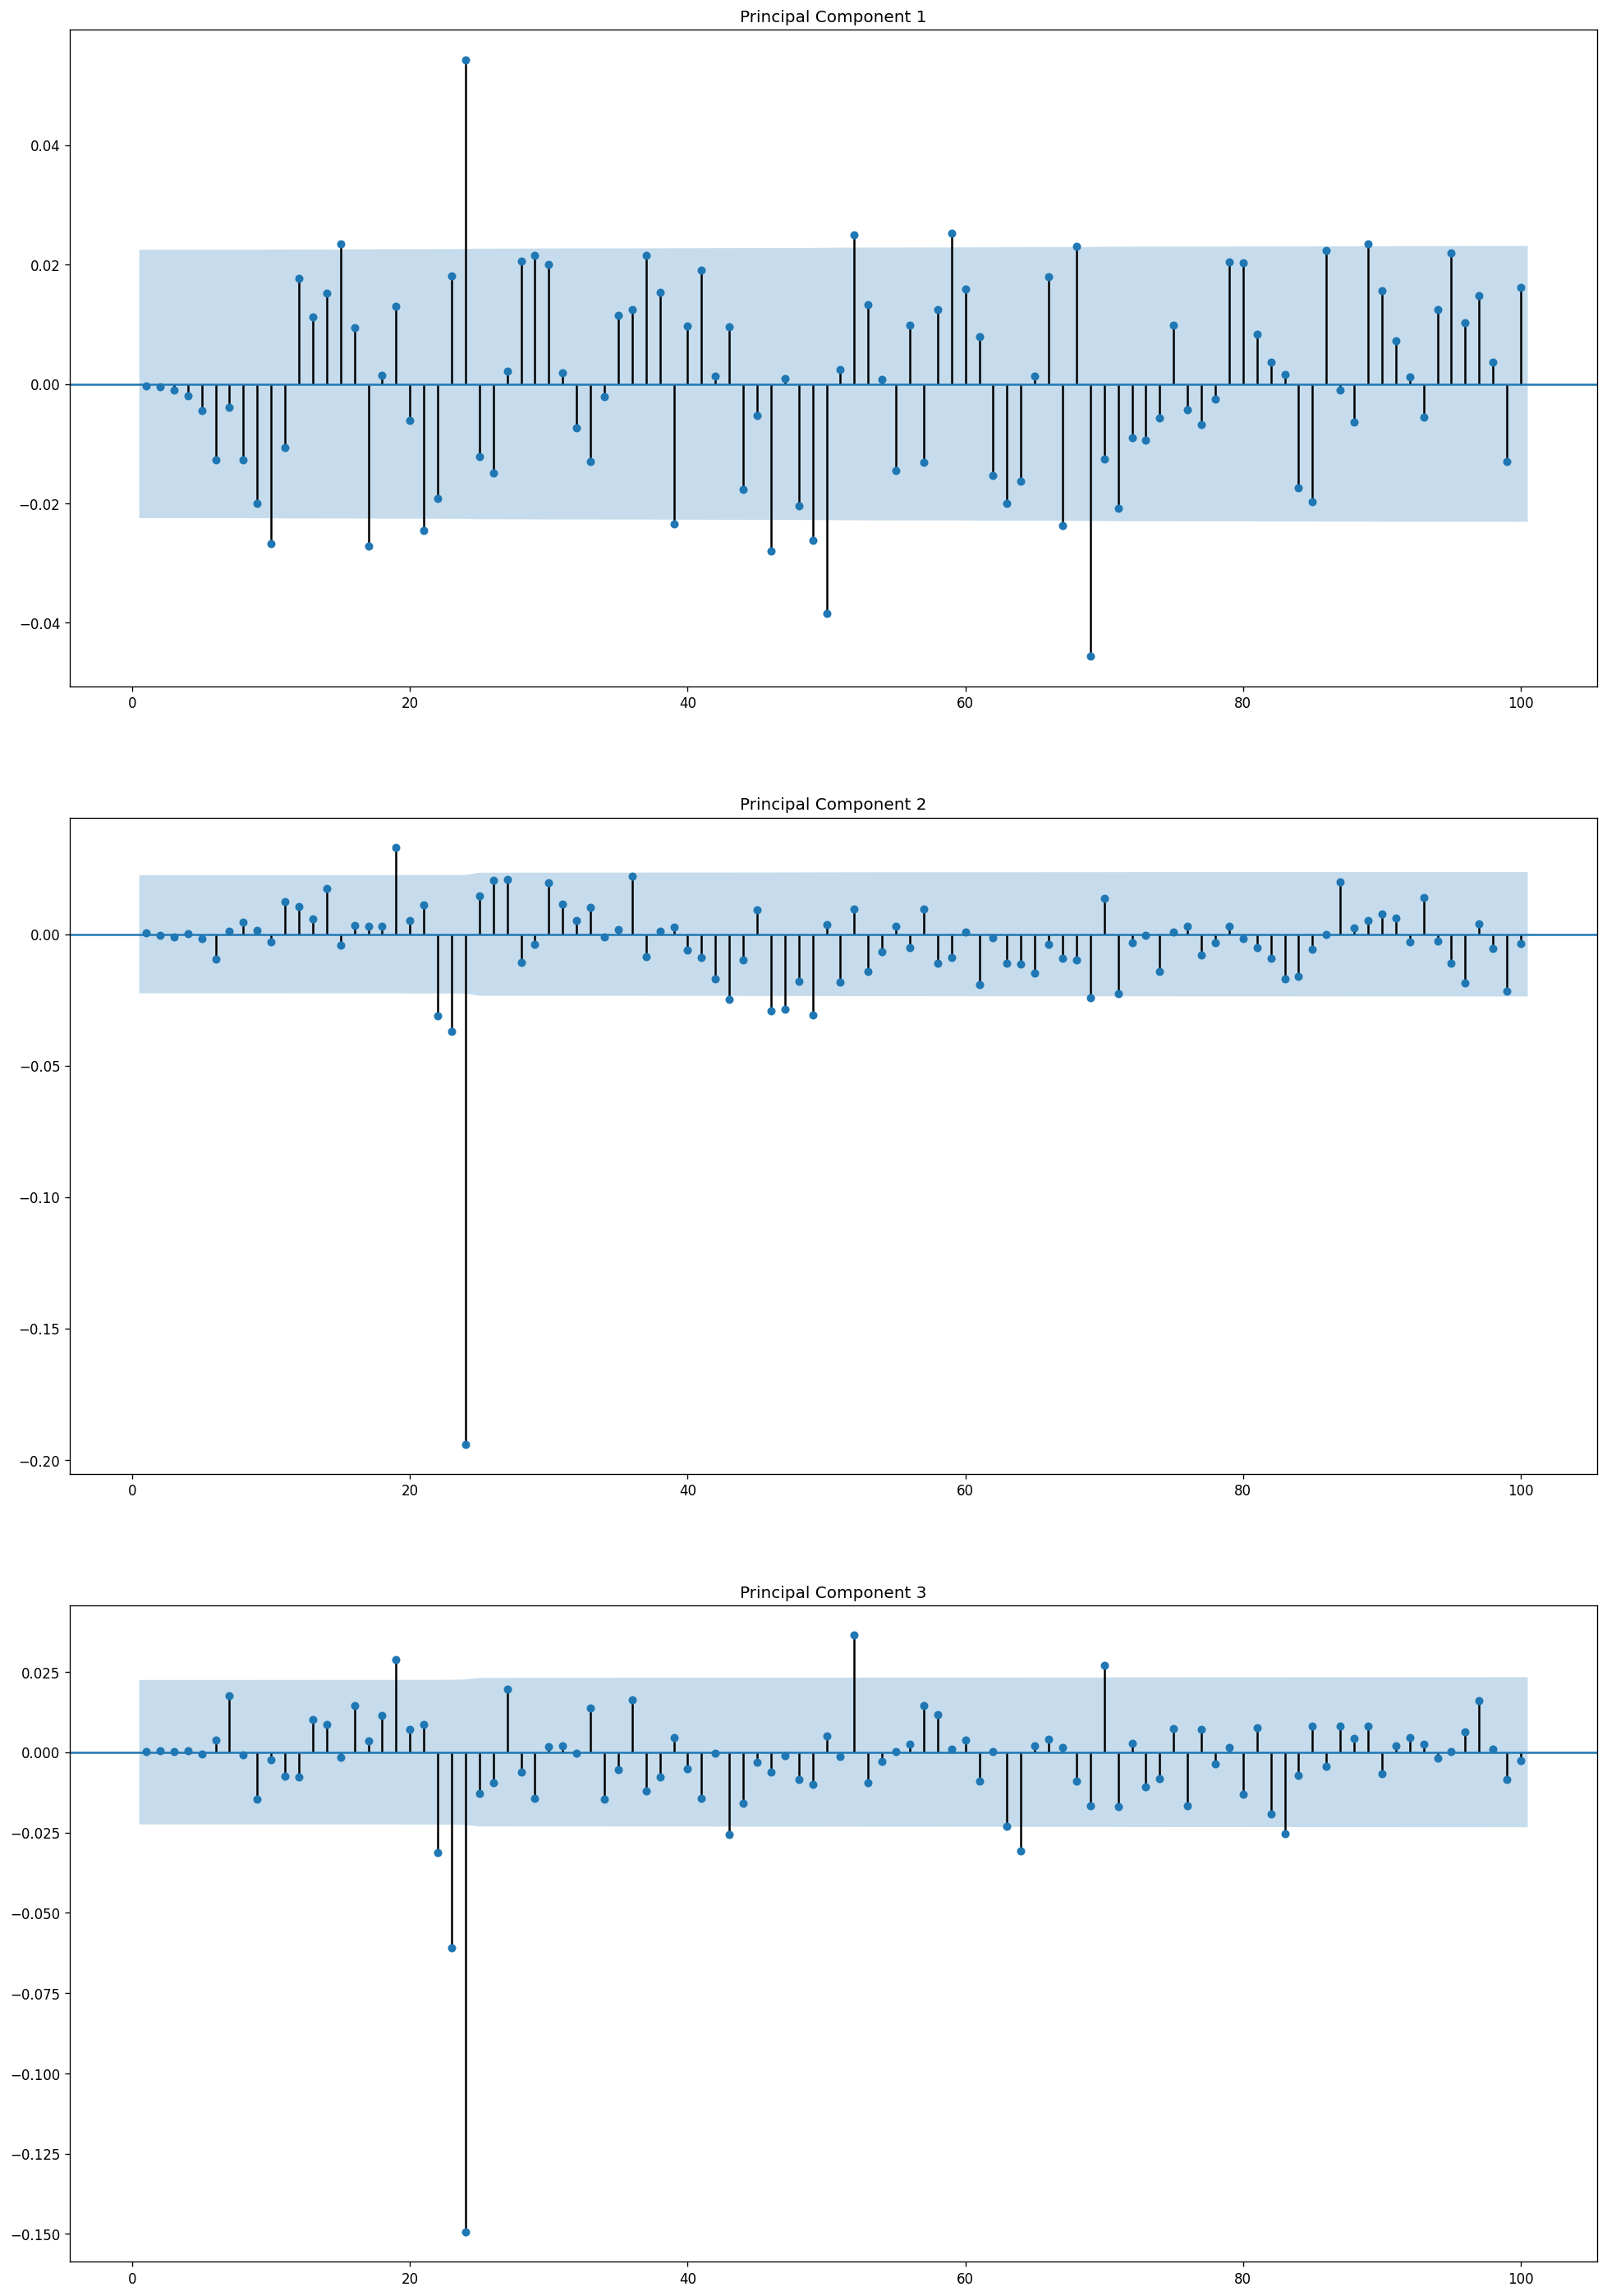

In [134]:
fig, axes = plt.subplots(nrows= num_cols, ncols=1, dpi=120, figsize=(20,30))
for i, ax in enumerate(axes.flatten()):
  smt.graphics.plot_acf(model_fitted.resid[df_pca.columns[i]], lags=100, ax =ax, title = df_pca.columns[i] , zero = False)

## Given below are the plots for the fitted values of the model on each time series. The blue line represents the fitted values and the red line represents the original transformed values.

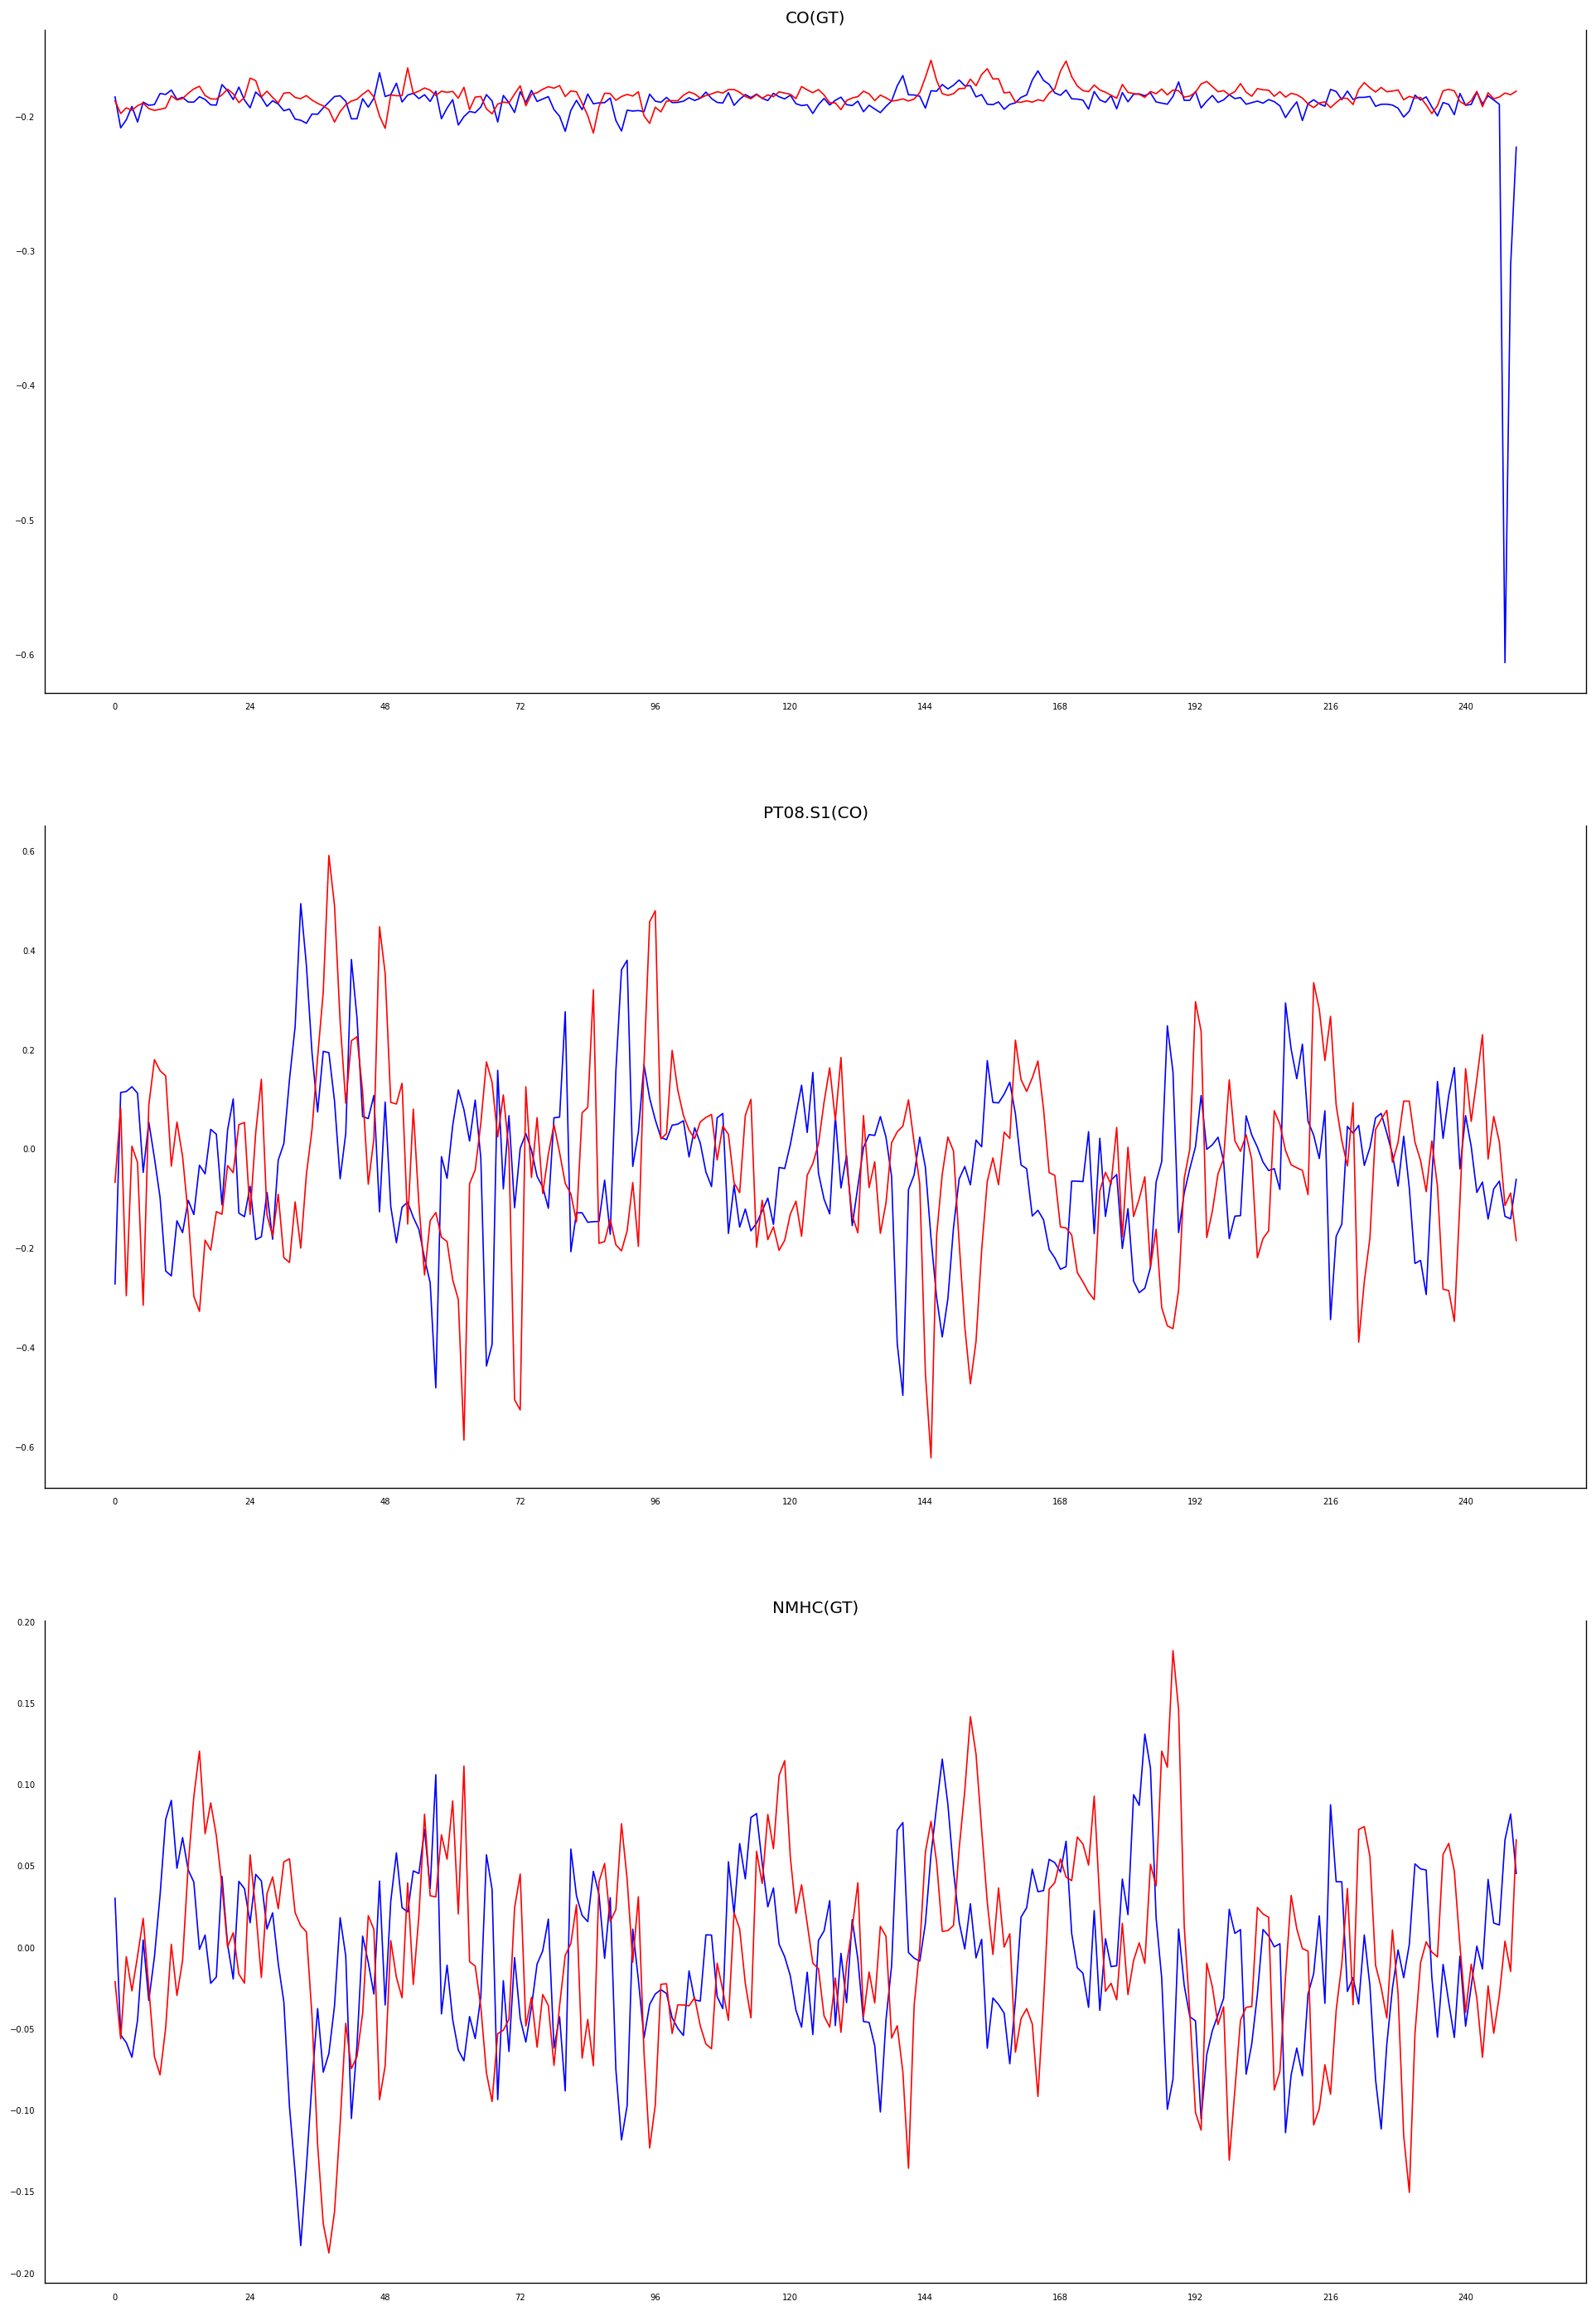

In [135]:
fig, axes = plt.subplots(nrows= num_cols, ncols=1, dpi=120, figsize=(20,30))
for i, ax in enumerate(axes.flatten()):
  data = model_fitted.fittedvalues[df_pca.columns[i]][:250]
  data_org = df_train[df_pca.columns[i]][:250]
  ax.set_xticks([x*24 for x in range(0,11)])
  ax.plot(range(len(data)), data, color='blue', linewidth=1, label = 'Fitted')
  ax.plot(range(len(data_org)), data_org, color='red', linewidth=1, label = 'Original')
  ax.set_title(df.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines["top"].set_alpha(0)
  ax.tick_params(labelsize=6)

## We finally forecast the model for 20 hours after the training set. The results are as shown below.

In [0]:
lag_order = model_fitted.k_ar
forecast_input = df_train.values[-lag_order:]

In [137]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df_pca.columns + '_1d')
df_forecast

Principal Component 1_1d  ...  Principal Component 3_1d
time                                           ...                          
03/04/2005 19.00.00                 -0.188722  ...                 -0.034872
03/04/2005 20.00.00                 -0.192557  ...                 -0.035087
03/04/2005 21.00.00                 -0.194894  ...                 -0.032172
03/04/2005 22.00.00                 -0.197751  ...                 -0.030678
03/04/2005 23.00.00                 -0.199884  ...                 -0.029172
04/04/2005 00.00.00                 -0.201887  ...                 -0.027844
04/04/2005 01.00.00                 -0.204113  ...                 -0.026697
04/04/2005 02.00.00                 -0.206235  ...                 -0.025711
04/04/2005 03.00.00                 -0.208281  ...                 -0.024862
04/04/2005 04.00.00                 -0.210253  ...                 -0.024143
04/04/2005 05.00.00                 -0.212150  ...                 -0.023531
04/04/2005 06.00.00                 -0.213983  ...                 -0.023009
04/04/2005 07.00.00                 -0.215759  ...                 -0.022564
04/04/2005 08.00.00                 -0.217479  ...                 -0.022183
04/04/2005 09.00.00                 -0.219144  ...                 -0.021860
04/04/2005 10.00.00                 -0.220754  ...                 -0.021584
04/04/2005 11.00.00                 -0.222313  ...                 -0.021351
04/04/2005 12.00.00                 -0.223821  ...                 -0.021153
04/04/2005 13.00.00                 -0.225280  ...                 -0.020986
04/04/2005 14.00.00                 -0.226693  ...                 -0.020845

[20 rows x 3 columns]

## We finally inverse the tranformed data to get the true original forecast.

In [0]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = pca.inverse_transform(df_forecast)
    df_fc = pd.DataFrame(data = df_fc, columns = df_train.columns + '_1d')
    columns = df_train.columns
    for i in range(len(columns)):
        col = columns[i]  
        df_fc[str(col)+ '_1d'] = np.exp(df_fc[str(col)+ '_1d']) 
        df_fc[str(col)+ '_1d'] = df_fc[str(col)+ '_1d'] - offsets[i]     
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+ '_1d'] = (df[col].iloc[-(nobs+1)]-df[col].iloc[-(nobs +2)]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        if i==0:
          df_fc[str(col) + '_forecast'] = df[col][-(nobs+72): -72].values + df_fc[str(col) + '_1d'].values
        else:
          df_fc[str(col) + '_forecast'] = df[col][-(nobs+24):-24].values + df_fc[str(col) + '_1d'].values
    return df_fc

df_forecast = invert_transformation(df, df_forecast, second_diff=False)  
num_cols = len(df.columns)


## Given below are the plots for the final forecasts for 20 hours for each time series (blue color). The ground truth is also plotted for each time series (orange color)

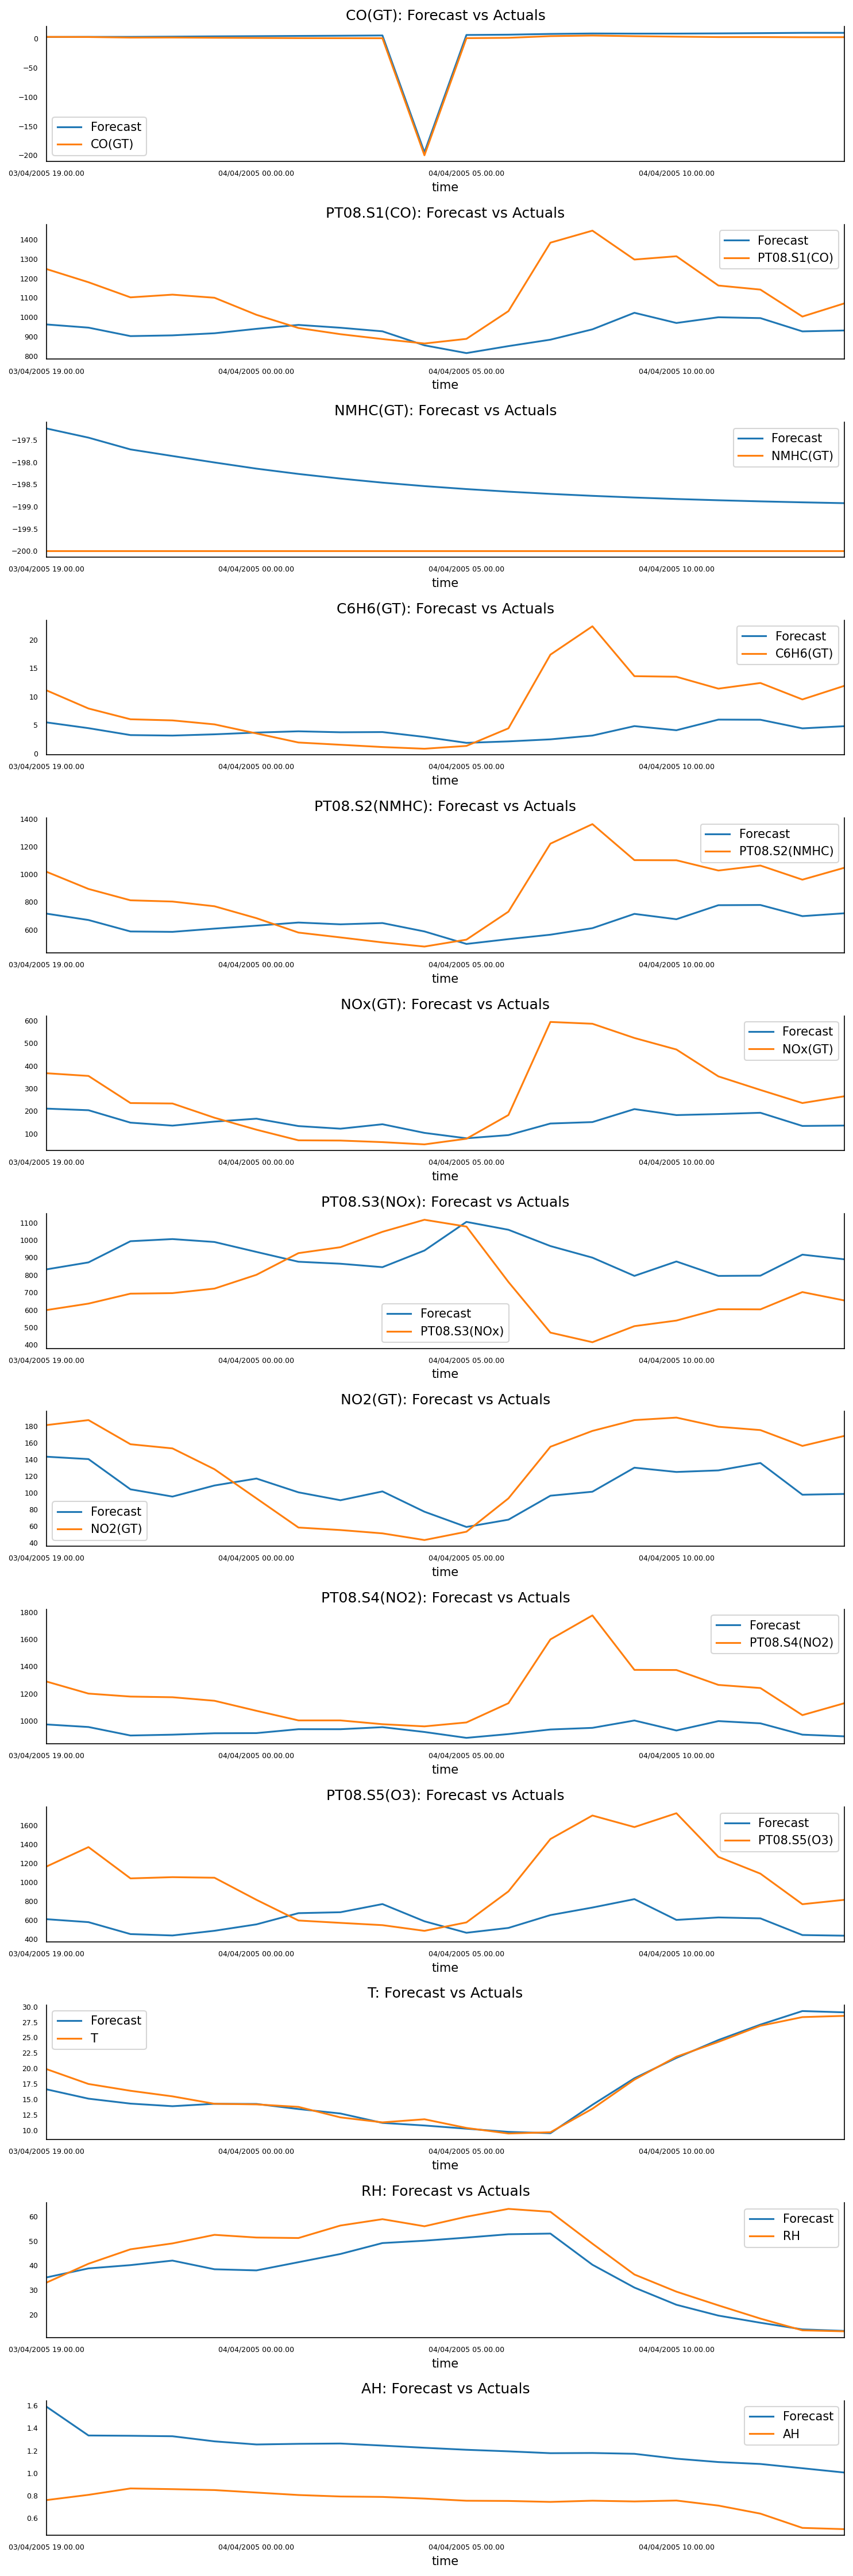

In [139]:
fig, axes = plt.subplots(nrows= num_cols, ncols=1, dpi=150, figsize=(20,30))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_forecast[col + '_forecast'].plot(label = 'Forecast', legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Given below are the evaluation metrics on the forecast for each time series 

In [140]:
df_results = df_forecast.copy()
df_results = df_results.apply(pd.to_numeric)
df_test = df_test[-nobs:].apply(pd.to_numeric)

from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

for i in range(num_cols):
  print()
  print('Forecast Accuracy of: ' + df_test.columns[i])
  accuracy_prod = forecast_accuracy(df_results[df_test.columns[i] + '_forecast'].values, df_test[df_test.columns[i]])
  for k, v in accuracy_prod.items():
      print(adjust(k), ': ', round(v,4))




Forecast Accuracy of: CO(GT)
mape   :  3.3287
me     :  4.0911
mae    :  4.1116
mpe    :  3.3185
rmse   :  4.6294
corr   :  0.9988
minmax :  0.6005

Forecast Accuracy of: PT08.S1(CO)
mape   :  0.1532
me     :  -175.7069
mae    :  184.6075
mpe    :  -0.1434
rmse   :  232.0626
corr   :  0.4151
minmax :  0.1531

Forecast Accuracy of: NMHC(GT)
mape   :  0.008
me     :  1.6003
mae    :  1.6003
mpe    :  -0.008
rmse   :  1.6755
corr   :  nan
minmax :  -0.0081

Forecast Accuracy of: C6H6(GT)
mape   :  0.7965
me     :  -4.2835
mae    :  5.2443
mpe    :  0.0019
rmse   :  7.0633
corr   :  0.3168
minmax :  0.5408

Forecast Accuracy of: PT08.S2(NMHC)
mape   :  0.2724
me     :  -217.4309
mae    :  259.0307
mpe    :  -0.1921
rmse   :  316.5663
corr   :  0.4187
minmax :  0.2653

Forecast Accuracy of: NOx(GT)
mape   :  0.5523
me     :  -114.5714
mae    :  144.2068
mpe    :  -0.1164
rmse   :  191.1628
corr   :  0.5803
minmax :  0.4484

Forecast Accuracy of: PT08.S3(NOx)
mape   :  0.3905
me     :  185.

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# **THE END**